# Мастерская 1

## Постановка задачи

Заказчик предоставил данные о стартапах, работавших в период с 1970 по 2018 годы. Задача состоит в создании модели, способной предсказать, какие из них прекратят свою деятельность.

**Цель исследования**

- **Разработать модель машинного обучения** для прогнозирования вероятности продолжения работы стартапа.  
- **Провести детальный разведочный анализ данных** и сформировать рекомендации для будущих основателей стартапов, выделив ключевые факторы, влияющие на успех бизнес-идеи.

**Описание данных**

Заказчик предоставил данные в двух файлах: тренировочный набор (около 53 тыс. записей) и тестовый набор (около 13 тыс. записей).  
Тренировочный набор содержит целевой признак `status`, указывающий на то, закрылся стартап или продолжает действовать.  

- **Временной период:** '1970-01-01' по '2018-01-01'.  
- **Дата формирования выгрузки:** '2018-01-01'.

**Структура данных**
- **`name`** — Название стартапа.  
- **`category_list`** — Список категорий, к которым относится стартап.  
- **`funding_total_usd`** — Общая сумма финансирования в USD.  
- **`status`** — Статус стартапа (закрыт или действующий).  
- **`country_code`** — Код страны.  
- **`state_code`** — Код штата.  
- **`region`** — Регион.  
- **`city`** — Город.  
- **`funding_rounds`** — Количество раундов финансирования.  
- **`founded_at`** — Дата основания.  
- **`first_funding_at`** — Дата первого раунда финансирования.  
- **`last_funding_at`** — Дата последнего раунда финансирования.  
- **`closed_at`** — Дата закрытия стартапа (если применимо).  
- **`lifetime`** — Время существования стартапа в днях.  



## План работ

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

# 1.Обзор данных

## 1.1. Библиотеки

### 1.1.1. Обновление

In [281]:
#!conda install -q phik
#!conda install plotly --upgrade -q
#!conda install --upgrade scikit-learn -q
#!conda install -q mlxtend
#!conda install -q shap
#!conda install matplotlib -q
#!conda install --upgrade imbalanced-learn
#!conda install --upgrade matplotlib
#!conda install --upgrade pandas numpy
#!conda install numpy

### 1.1.2. Импорт

In [282]:

# Импорт из стандартной библиотеки
import os  # Функционал ОС (запись файлов, управление директориями и т.п.)
import random
import warnings
from collections import Counter

# Стандартные библиотеки для исследований
import numpy as np
import pandas as pd

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap  # Метод SHAP

# Модели машинного обучения
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Метрики оценки качества модели
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    r2_score,
    average_precision_score,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# Предобработка данных
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance

# Разбиение данных и выбор модели
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)

# Построение пайплайнов
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Дополнительные библиотеки для анализа данных
from ydata_profiling import ProfileReport
import sweetviz as sv
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Инструменты для работы с несбалансированными данными
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # SMOTE в пайплайне

# Бустинг
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Отключение предупреждений
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Настройка отображения графиков
%matplotlib inline
shap.initjs()  # Инициализация SHAP

sns.set(
    font_scale=1.3,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
)




## 1.2. Константы

In [283]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
line_1 = '-'*50 #линия 
line_2 = '_'*50#линия

## 1.3. Функции проекта

### 1.3.1. Функция для загрузки данных

In [284]:
def load_data(file_path, remote_url, sep=';', decimal=','):
    """
    Функция для загрузки данных из локального файла или удаленного источника.

    Аргументы:
    - file_path: Путь к локальному файлу.
    - remote_url: URL для загрузки данных, если локальный файл не найден.
    - sep: Разделитель в файле CSV (по умолчанию ';').
    - decimal: Символ для разделения десятичных дробей (по умолчанию ',').

    Возвращает:
    - pd.DataFrame с загруженными данными, если загрузка успешна.
    - None, если загрузка завершилась ошибкой.
    """
    try:
        # Попытка загрузить данные из локального файла
        if os.path.exists(file_path):
            print(f'Загрузка данных из локального файла: {file_path}')
            return pd.read_csv(file_path, sep=sep, decimal=decimal)

        # Если локального файла нет, загружаем из удаленного источника
        print(f'Локальный файл не найден. Загрузка данных из удаленного источника: {remote_url}')
        return pd.read_csv(remote_url, sep=sep, decimal=decimal)

    except FileNotFoundError:
        print(f"Файл не найден по пути: {file_path} и недоступен удаленный источник: {remote_url}")
        return None

    except pd.errors.EmptyDataError:
        print("Ошибка: Пустой файл CSV.")
        return None

    except Exception as e:
        # Обработка любых других ошибок
        print(f'Загрузка произошла с ошибкой: {e}')
        return None

### 1.3.2. Функция для отображения информации о датафрейме

In [285]:
def display_dataframe_info(name, dataframe):
    """
    Функция для отображения информации о датафрейме:
    - Первые 5 строк
    - Статистическое описание
    - Информация о датафрейме
    - Количество уникальных значений в столбце 'id'
    """
    print(f'\n\n# Информация о датафрейме: {name}\n')

    # Отображаем статистическое описание числовых столбцов
    display(dataframe.describe())

    # Отображаем первые 5 строк датафрейма
    display(dataframe.head())

    # Выводим информацию о датафрейме
    print("\nОбщая информация:")
    dataframe.info(verbose=True, memory_usage=True)

    # Подсчитываем количество уникальных 'name', если столбец существует
    if 'name' in dataframe.columns:
        unique_id_count = dataframe['name'].nunique()
        print(f"\nКоличество уникальных 'name' в {name}: {unique_id_count}")
    else:
        print(f"\nСтолбец 'name' отсутствует в датафрейме {name}.")

### 1.3.3. Функция для отображения уникальных колонок (при выявлении неявных дубликатов)

In [286]:
def get_unique_values(df, columns, df_name):
    """
    Возвращает словарь с уникальными значениями для указанных колонок из датафрейма.

    Параметры:
    - df: pd.DataFrame — датафрейм для анализа.
    - columns: list — список колонок для анализа.
    - df_name: str — имя датафрейма (например, 'df_train' или 'df_test').

    Возвращает:
    - dict: Словарь с уникальными значениями.
    """
    unique_values_dict = {}
    for column in columns:
        unique_values = sorted(df[column].dropna().unique())
        unique_values_dict[column] = {
            'count': len(unique_values),
            'values': unique_values,
            'df_name': df_name
        }
    return unique_values_dict

## 1.3. Загрузка и просмотр данных

### 1.3.1. Загружаем данные

In [287]:
# Определяем список файлов с их параметрами
data_files = [
    {
        'name': 'df_train',
        'file_path': 'datasets/kaggle_startups_train_28062024.csv',
        'remote_url': '',
        'sep': ',',
        'decimal': '.'
    },
    {
        'name': 'df_test',
        'file_path': 'datasets/kaggle_startups_test_28062024.csv',
        'remote_url': '',
        'sep': ',',
        'decimal': '.'
    },
]

# Создаем словарь для хранения загруженных датафреймов
df_dict = {}

# Проходим по каждому файлу и загружаем данные
for data in data_files:
    name = data['name']
    file_path = data['file_path']
    remote_url = data['remote_url']
    sep = data.get('sep', ',')        # По умолчанию ','
    decimal = data.get('decimal', '.') # По умолчанию '.'
    data_frame = load_data(file_path, remote_url, sep=sep, decimal=decimal)
    df_dict[name] = data_frame

# Извлекаем список датафреймов
df = list(df_dict.values())

# Извлекаем список имен датафреймов
df_names = list(df_dict.keys())

Загрузка данных из локального файла: datasets/kaggle_startups_train_28062024.csv
Загрузка данных из локального файла: datasets/kaggle_startups_test_28062024.csv


### 1.3.2. Просмотр данных

In [288]:
# Используем функцию для каждого датафрейма
for name, dataframe in zip(df_names, df):
    display_dataframe_info(name, dataframe)



# Информация о датафрейме: df_train



funding_total_usd  funding_rounds
count          42,447.00       52,516.00
mean       18,247,480.66            1.74
std       187,117,301.32            1.37
min                 1.00            1.00
25%           336,027.50            1.00
50%         2,000,000.00            1.00
75%        10,000,000.00            2.00
max    30,079,503,000.00           19.00

name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0         828,626.00  operating          CHE         25       Zurich   
1      42,935,019.00  operating          USA         CA  SF Bay Area   
2      35,456,381.00  operating          USA         CA  SF Bay Area   
3      22,250,000.00  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2009-10-17       2011-05-01      2014-12-01   
1  Redwood City               4  2005-01-01       2010-05-04      2014-02-25   
2      San Jose               3  2006-01-01       2012-08-20      2014-07-02   
3           NaN               3  2004-01-01       2011-09-01      2014-07-18   
4       Bristol               1  2010-05-12       2012-02-01      2012-02-01   

  closed_at  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB

Количество уникальных 'name' в df_train: 52515


# Информация о датафрейме: df_test



funding_total_usd  funding_rounds  lifetime
count          10,547.00       13,125.00 13,125.00
mean       16,549,102.70            1.71  3,097.61
std        92,172,825.63            1.32  2,128.36
min                 1.00            1.00     52.00
25%           320,000.00            1.00  1,726.00
50%         2,000,000.00            1.00  2,526.00
75%        10,000,000.00            2.00  3,866.00
max     4,715,000,000.00           15.00 17,167.00

name                   category_list  funding_total_usd  \
0              Crystalsol                Clean Technology       2,819,200.00   
1        JBI Fish & Wings                     Hospitality                NaN   
2                COINPLUS                         Finance         428,257.00   
3  Imagine Communications  Software|Video|Video Streaming      34,700,000.00   
4                   DNA13                        Software       4,530,000.00   

  country_code state_code            region              city  funding_rounds  \
0          NIC         17               NaN               NaN               1   
1          USA         TN        TN - Other          Humboldt               1   
2          LUX          3  Esch-sur-alzette  Esch-sur-alzette               2   
3          USA         CA         San Diego         San Diego               4   
4          CAN         ON            Ottawa            Ottawa               1   

  first_funding_at last_funding_at  lifetime  
0       2009-07-01      2009-07-01      3501  
1       2010-07-28      2010-07-28      2717  
2       2014-05-15      2014-09-18      1295  
3       2005-01-01      2010-04-20      4748  
4       2007-05-08      2007-05-08      6209


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB

Количество уникальных 'name' в df_test: 13125


In [289]:
# Сохраним размер датафреймов
df_train_shape = df[0].shape
df_test_shape = df[1].shape
print(df_train_shape)
print(df_test_shape)


(52516, 13)
(13125, 11)


## 1.4. Выводы

**1. Размер и структура датасетов**
- **`df_train`**: 52,516 строк, 13 колонок.
- **`df_test`**: 13,125 строк, 11 колонок.


**Общие колонки**
- `name`: Название стартапа.
- `category_list`: Список категорий стартапа.
- `funding_total_usd`: Общая сумма финансирования в USD.
- `country_code`: Код страны.
- `state_code`: Код штата.
- `region`: Регион.
- `city`: Город.
- `funding_rounds`: Количество раундов финансирования.
- `first_funding_at`: Дата первого раунда финансирования.
- `last_funding_at`: Дата последнего раунда финансирования.

**Уникальные колонки**
- **`df_train`**:
  - `status`: Статус стартапа (закрыт или действующий). `Целевой признак`.
  - `founded_at`: Дата основания.
  - `closed_at`: Дата закрытия стартапа (если применимо).
- **`df_test`**:
  - `lifetime`: Время существования стартапа в днях.

---

**Пропуски данных**
**Основные колонки с пропусками:**
- **`funding_total_usd`**:
  - `df_train`: 19.2% пропусков (42,447/52,516 заполнено).
  - `df_test`: 19.2% пропусков (10,547/13,125 заполнено).
- **`category_list`**:
  - `df_train`: 4.7% пропусков.
  - `df_test`: 4.5% пропусков.
- **`country_code`**:
  - `df_train`: 10.5% пропусков.
  - `df_test`: 10.6% пропусков.

**Уникальные пропуски:**
- **`df_train`**:
  - `closed_at`: 90.6% пропусков (4917/52,516 заполнено).
  - `founded_at`: Полностью заполнена.
- **`df_test`**:
  - `lifetime`: Полностью заполнена.

---

**3. Статистическое распределение числовых колонок**

**3.1. `funding_total_usd` (общая сумма финансирования)**
- **`df_train`**:
  - Среднее: 18,247,480, медиана: 2,000,000.
  - Стандартное отклонение: 187,117,300.
  - Диапазон: от 1 до 30,079,500,000.
- **`df_test`**:
  - Среднее: 16,549,100, медиана: 2,000,000.
  - Стандартное отклонение: 92,172,830.
  - Диапазон: от 1 до 4,715,000,000.

**3.2. `funding_rounds` (количество раундов финансирования)**
- **`df_train`**:
  - Среднее: 1.74, медиана: 1.
  - Диапазон: от 1 до 19.
- **`df_test`**:
  - Среднее: 1.71, медиана: 1.
  - Диапазон: от 1 до 15.

**3.3. `lifetime` (время существования стартапа в днях, только в `df_test`)**
- Среднее: 3,097 дней (примерно 8.5 лет).
- Диапазон: от 52 до 17,167 дней.

---

**4. Уникальные значения**
- Количество уникальных `name`:
  - **`df_train`**: 52,515 (почти полное отсутствие дубликатов).
  - **`df_test`**: 13,125 (полное отсутствие дубликатов).

---

**5. Временные данные**
- **Общие данные**: Оба датасета содержат временные метки `first_funding_at` и `last_funding_at`, полностью заполненные.
- **Уникальные данные**:
  - **`df_train`**:
    - `founded_at`: Информация доступна для всех строк.
    - `closed_at`: Значительные пропуски (~90.6%), что ожидаемо, так как многие стартапы не закрыты.
  - **`df_test`**:
    - `lifetime`: Вычислено как разница между `last_funding_at` и `founded_at`.

---

**6. Сравнение распределений**
- Основные числовые показатели, такие как `funding_total_usd` и `funding_rounds`, схожи по средним значениям и распределению.
- Выбросы в `funding_total_usd`:
  - `df_train` имеет более широкий диапазон значений (1 до 30,079,500,000), чем `df_test` (1 до 4,715,000,000).

---

**7. Рекомендации для анализа**
1. **Устранение пропусков**:
   - Заполнить пропуски в колонках `funding_total_usd`, `category_list`, `country_code` и других.
   - Для `closed_at` заменить пропуски на дату выгрузки `2018-01-01`.

2. **Изменить типы данных**:
   - В founded_at, first_funding_at, last_funding_at, closed_at тип данных object изменить на datetime64.

3. **Обогащение данных**:
   - Вычислить `lifetime` для `df_train` как разницу между `last_funding_at` и `founded_at`.

4. **Анализ статуса стартапов**:
   - Проанализировать колонку `status` из `df_train`, чтобы выделить особенности закрытых стартапов.

5. **Проверка корреляций**:
   - Исследовать связь между `funding_rounds` и `funding_total_usd`.
   - Для закрытых стартапов проверить, как срок существования (`lifetime`) влияет на вероятность закрытия.

6. **Удаление выбросов**:
   - Рассмотреть исключение выбросов для `funding_total_usd` при построении моделей.

7. **Временной анализ**:
   - Провести анализ трендов финансирования по годам, используя `first_funding_at` и `last_funding_at`.

---

**8. Вывод**
- Оба датасета схожи по структуре и распределению ключевых данных, что упрощает их объединение.
- `df_train` содержит больше информации о статусе стартапов и времени их существования до закрытия.
- `df_test` добавляет полезный атрибут `lifetime`, который можно рассчитать и для `df_train`.


# 2.Предобработка данных

## 2.1. Наличие пропусков

In [290]:
# Значения для замены пропусков в тренировочном наборе df_train
fill_values_train = {
    'name': 'no_name',
    'category_list': 'no_category',
    'country_code': 'no_country',
    'state_code': 'no_state',
    'region': 'no_region',
    'city': 'no_city',
    'closed_at': '2018-01-01'
}

# Значения для замены пропусков в тестовом наборе df_test
fill_values_test = {
    'category_list': 'no_category',
    'country_code': 'no_country',
    'state_code': 'no_state',
    'region': 'no_region',
    'city': 'no_city'
}

# Заполняем пропуски в тренировочном наборе df_train
df[0].fillna(value=fill_values_train, inplace=True)

# Заполняем пропуски в тестовом наборе df_test
df[1].fillna(value=fill_values_test, inplace=True)


In [291]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          52516 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [292]:
# Замена пропусков в столбце 'funding_total_usd' для обоих датафреймов на медианное значение 
#сгруппированное по значению в столбце 'funding_rounds'
for d in df:
    # Вычисляем медианы для каждой группы 'funding_rounds'
    medians = d.groupby('funding_rounds')['funding_total_usd'].median()
    
    # Замена пропусков на медианы в зависимости от значения 'funding_rounds'
    d['funding_total_usd'] = d.apply(
        lambda row: medians[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
        axis=1
    )


In [293]:
# Валидируем результат устранения пропусков
for name, dataframe in zip(df_names, df):
    print(f'Количество пропусков в датафрейме "{name}": {dataframe.isna().sum().sum()}')

Количество пропусков в датафрейме "df_train": 0
Количество пропусков в датафрейме "df_test": 0


## 2.2. Изменить типы данных

In [294]:
#В founded_at, first_funding_at, last_funding_at, closed_at тип данных object изменить на datetime64
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in date_columns:
    df[0][col] = pd.to_datetime(df[0][col], errors='coerce')
    print(f"Столбец {col} в df_train изменен тип на datetime64[ns].")
    if col in df[1].columns:
        df[1][col] = pd.to_datetime(df[1][col], errors='coerce')
        print(f"Столбец {col} в df_test изменен тип на datetime64[ns].")


Столбец founded_at в df_train изменен тип на datetime64[ns].
Столбец first_funding_at в df_train изменен тип на datetime64[ns].
Столбец first_funding_at в df_test изменен тип на datetime64[ns].
Столбец last_funding_at в df_train изменен тип на datetime64[ns].
Столбец last_funding_at в df_test изменен тип на datetime64[ns].
Столбец closed_at в df_train изменен тип на datetime64[ns].


In [295]:
#Валидация
for d in df:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

## 2.3. Наличие явных дубликатов

In [296]:
for name, dataframe in zip(df_names, df):
    print(f"Проверка: {name}, тип DataFrame: {type(dataframe)}")
    print(f'Количество явных дубликатов в {name}: {dataframe.duplicated().sum()}')


Проверка: df_train, тип DataFrame: <class 'pandas.core.frame.DataFrame'>
Количество явных дубликатов в df_train: 0
Проверка: df_test, тип DataFrame: <class 'pandas.core.frame.DataFrame'>
Количество явных дубликатов в df_test: 0


Явных дубликатов не выявлено.

## 2.4. Наличие неявных дубликатов

In [297]:
# Используем функцию в п.1.3.3.
columns_to_check = ['country_code'] #словарь с анализируемыми columns 
unique_values_train = get_unique_values(df[0], columns_to_check, 'df_train')
unique_values_test = get_unique_values(df[1], columns_to_check, 'df_test')

# Вывод результата
for df_name, unique_values_dict in [('df_train', unique_values_train), ('df_test', unique_values_test)]:
    print(f"Уникальные значения из {df_name}:")
    for column, info in unique_values_dict.items():
        print(f"  - Колонка '{column}' ({info['count']} шт.): {info['values']}")
    print()


Уникальные значения из df_train:
  - Колонка 'country_code' (135 шт.): ['ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BAH', 'BEL', 'BGD', 'BGR', 'BHR', 'BLM', 'BLR', 'BLZ', 'BMU', 'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CYM', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GRC', 'GRD', 'GTM', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAF', 'MAR', 'MCO', 'MDA', 'MEX', 'MKD', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MYS', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'PSE', 'QAT', 'ROM', 'RUS', 'RWA', 'SAU', 'SEN', 'SGP', 'SLV', 'SOM', 'SRB', 'SVK', 'SVN', 'SWE', 'SYC', 'TAN', 'TGO', 'THA', 'TTO', 'TUN', 'TUR', 'TWN', 'UGA', 'UKR', 'URY', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'ZMB

Не выявлены неявные дубликаты

Выявлены опечатки к кодах стран 
Необходимо:
1. "ROM" заменить на "ROU"
2. "TAN" заменить на "TZA"
3. "BAH" заменить на "BHS"

In [298]:
# Создаем словарь замен
replacements = {
    "ROM": "ROU",
    "TAN": "TZA",
    "BAH": "BHS"
}

# Применяем замену к df[0] и df[1]
for name, dataframe in zip(df_names, df):
    dataframe['country_code'] = dataframe['country_code'].replace(replacements)

In [299]:
# Используем функцию в п.1.3.3.
columns_to_check = ['country_code'] #словарь с анализируемыми columns 
unique_values_train = get_unique_values(df[0], columns_to_check, 'df_train')
unique_values_test = get_unique_values(df[1], columns_to_check, 'df_test')

# Вывод результата
for df_name, unique_values_dict in [('df_train', unique_values_train), ('df_test', unique_values_test)]:
    print(f"Уникальные значения из {df_name}:")
    for column, info in unique_values_dict.items():
        print(f"  - Колонка '{column}' ({info['count']} шт.): {info['values']}")
    print()

Уникальные значения из df_train:
  - Колонка 'country_code' (135 шт.): ['ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BGD', 'BGR', 'BHR', 'BHS', 'BLM', 'BLR', 'BLZ', 'BMU', 'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CYM', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GRC', 'GRD', 'GTM', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAF', 'MAR', 'MCO', 'MDA', 'MEX', 'MKD', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MYS', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'PSE', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN', 'SGP', 'SLV', 'SOM', 'SRB', 'SVK', 'SVN', 'SWE', 'SYC', 'TGO', 'THA', 'TTO', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'ZMB

## 2.5. Синтетические признаки

### 2.5.1. Добавим `lifetime` в `df_train`

Столбец `lifetime` расчитаем как разницу между `closed_at` и `founded_at` в df_train

In [300]:
df[0]['lifetime'] = (df[0]['closed_at'] - df[0]['founded_at']).dt.days
print(df[0]['lifetime'])


0        2998
1        4748
2        4383
3        5114
4        2791
         ... 
52511    2192
52512    1590
52513    2741
52514    7336
52515    1969
Name: lifetime, Length: 52516, dtype: int64


### 2.5.2. Сгруппируем `lifetime` в датасетах

In [301]:
#Зададим периоды, общепринятые при анализе компаний
bins = [0, 365, 1095, 1825, float('inf')]
labels = ['<1 года', '1-3 лет', '3-5 лет', '>5 лет']

#df_train
df[0]['lifetime_group'] = pd.cut(df[0]['lifetime'], bins=bins, labels=labels)

#df_test
df[1]['lifetime_group'] = pd.cut(df[1]['lifetime'], bins=bins, labels=labels)


In [302]:
# Подсчёт распределения по группам для двух датасетов
train_counts = df[0]['lifetime_group'].value_counts().sort_index()
test_counts = df[1]['lifetime_group'].value_counts().sort_index()

# Создание холста с двумя круговыми диаграммами
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'pie'}, {'type': 'pie'}]],  # Указываем тип диаграмм
    subplot_titles=("Train Dataset", "Test Dataset")
)

# Круговая диаграмма для train
fig.add_trace(
    go.Pie(
        labels=train_counts.index.astype(str),
        values=train_counts.values,
        name="Train Dataset"
    ),
    row=1, col=1
)

# Круговая диаграмма для test
fig.add_trace(
    go.Pie(
        labels=test_counts.index.astype(str),
        values=test_counts.values,
        name="Test Dataset"
    ),
    row=1, col=2
)

# Настройка макета
fig.update_layout(
    title_text="Распределение времени жизни компаний: Train vs Test",
    height=600,
    width=1000
)

# Показать диаграммы
fig.show()


### 2.5.3. Структурируем данные в `category_list` 

#### 2.5.3.1. Выделим одно направление деятельности - первое, т.к. общепринято указывать основной вид деятельности первым

In [303]:
# Для DataFrame df[0]
df[0]['category_first_word'] = df[0]['category_list'].apply(
    lambda x: x.split('|')[0].strip().lower() if isinstance(x, str) else x
)

# Для DataFrame df[1]
df[1]['category_first_word'] = df[1]['category_list'].apply(
    lambda x: x.split('|')[0].strip().lower() if isinstance(x, str) else x
)

# Проверка результата
print(df[0][['category_list', 'category_first_word']].head())
print(df[1][['category_list', 'category_first_word']].head())


                           category_list  category_first_word
0        Online Reservations|Restaurants  online reservations
1  Manufacturing|Medical|Medical Devices        manufacturing
2                          Biotechnology        biotechnology
3                            Health Care          health care
4                          Manufacturing        manufacturing
                    category_list category_first_word
0                Clean Technology    clean technology
1                     Hospitality         hospitality
2                         Finance             finance
3  Software|Video|Video Streaming            software
4                        Software            software


Проанализируем категории на уникальность и схожесть

In [304]:
df[0]['category_first_word'].unique()[:5]

array(['online reservations', 'manufacturing', 'biotechnology',
       'health care', 'mobile'], dtype=object)

#### 2.5.3.2. Объединим виды деятельности в группы по направлениям деятельности

**Используем для группировки - Международную стандартную отраслевую классификацию видов экономической деятельности (ISIC)** 

**ISIC (International Standard Industrial Classification)** — это международный классификатор видов экономической деятельности, разработанный Статистической комиссией ООН. Он обеспечивает единообразный подход к классификации и сравнительному анализу экономической активности во всем мире, служит основой для национальных и региональных классификаций.

Актуальной на сегодня является редакция **ISIC Rev.4**.

Официальная информация о ISIC доступна на сайте ООН: [https://unstats.un.org/unsd/classifications/Econ/isic](https://unstats.un.org/unsd/classifications/Econ/isic)

**Верхнеуровневые разделы ISIC Rev.4**

| Код | Название на русском |
|-----|---------------------|
| A   | Сельское, лесное хозяйство и рыболовство |
| B   | Добыча полезных ископаемых |
| C   | Обрабатывающая промышленность |
| D   | Снабжение электроэнергией, газом, паром и кондиционированным воздухом |
| E   | Водоснабжение; водоотведение, организация сбора и утилизации отходов, деятельность по ликвидации загрязнений |
| F   | Строительство |
| G   | Оптовая и розничная торговля; ремонт автотранспортных средств и мотоциклов |
| H   | Транспортировка и хранение |
| I   | Деятельность по предоставлению мест для временного проживания и питания |
| J   | Информация и связь |
| K   | Финансовая и страховая деятельность |
| L   | Операции с недвижимым имуществом |
| M   | Профессиональная, научная и техническая деятельность |
| N   | Деятельность административная и сопутствующие дополнительные услуги |
| O   | Государственное управление и обеспечение военной безопасности; обязательное социальное обеспечение |
| P   | Образование |
| Q   | Здравоохранение и социальные услуги |
| R   | Искусство, развлечения и отдых |
| S   | Прочие виды услуг |
| T   | Деятельность домашних хозяйств как работодателей; производство товаров и оказание услуг домашними хозяйствами для собственного потребления |
| U   | Деятельность экстерриториальных организаций и органов |


In [305]:
#Объединим category_first_word в отдельный список
combined_unique = pd.concat([df[0]['category_first_word'], df[1]['category_first_word']]).unique()
len(combined_unique)

728

In [306]:
# Определяем словарь соответствия
group_mapping = {
    'online reservations': 'J',
    'manufacturing': 'C',
    'biotechnology': 'C',
    'health care': 'Q',
    'mobile': 'J',
    'analytics': 'J',
    'software': 'J',
    'semiconductors': 'C',
    'clean technology': 'C',
    'no_category': 'NO_CATEGORY',
    'nanotechnology': 'C',
    'customer service': 'N',
    'banking': 'K',
    'messaging': 'J',
    'consumers': 'S',
    'generation y-z': 'S',
    'college recruiting': 'P',
    'technology': 'J',
    'finance': 'K',
    'cloud computing': 'J',
    'diy': 'S',
    'entertainment': 'R',
    'internet': 'J',
    'advertising': 'M',
    'fitness': 'S',
    'consumer goods': 'S',
    'moneymaking': 'S',
    'media': 'J',  
    'apps': 'J',
    'enterprises': 'S',
    'adventure travel': 'R',
    'travel': 'S',  # Без уточнения - просто услуги, хотя можно I, но не ясно про размещение
    'home owners': 'S',
    'e-commerce': 'G',
    'collaboration': 'J',
    '3d': 'C',  
    'medical': 'Q',
    'big data analytics': 'J',
    'business services': 'N',
    'local businesses': 'S',
    'sports': 'R',
    'curated web': 'J',
    'cloud security': 'J',
    'advanced materials': 'C',
    'fashion': 'R',
    'e-books': 'J',
    'real estate': 'L',
    'social network media': 'J',
    'enterprise software': 'J',
    'architecture': 'F',
    'music': 'R',
    'broadcasting': 'J',  
    'eyewear': 'C', # Товары могут быть C (производство), но без уточнения - примем как производство
    'event management': 'M',
    'healthcare services': 'Q',
    'health and wellness': 'Q',
    'automotive': 'C', # Автомобили - производство
    'education': 'P',
    'direct sales': 'G', 
    'events': 'S',  
    'digital media': 'J',
    'pharmaceuticals': 'C',
    'games': 'R',
    'energy': 'D',
    'hardware + software': 'J',
    'babies': 'S',
    'home decor': 'S',
    'marketing automation': 'M',
    'auctions': 'G',
    'information technology': 'J',
    'film': 'R',
    'polling': 'M', # Исследование, опрос - ближе к проф. услугам (M)
    'artificial intelligence': 'J',
    'finance technology': 'K', # Финтех
    'application platforms': 'J',
    'beauty': 'S',
    'accounting': 'K',
    'consulting': 'M',
    'services': 'S',
    'coupons': 'G',
    'organic food': 'C', # Пищ. производство
    'design': 'M',
    'brand marketing': 'M',
    'android': 'J',
    'angels': 'K', # Инвесторы (фин. сфера)
    'advertising exchanges': 'M',
    'augmented reality': 'J',
    'saas': 'J',
    'content': 'J',
    'audio': 'J',
    'business development': 'M',
    'auto': 'C',
    'transportation': 'H',
    'life sciences': 'C',
    'alumni': 'S',
    'bicycles': 'C',  
    'online shopping': 'G',
    'ad targeting': 'M',
    'marketplaces': 'G',
    '3d printing': 'C',
    'engineering firms': 'M',
    'data visualization': 'J',
    'web hosting': 'J',
    'information security': 'J',
    'hospitality': 'I',
    'communications hardware': 'J',
    'art': 'R',
    'big data': 'J',
    'computers': 'C', # Производство компьютеров - C
    'infrastructure': 'S', # без уточнений - прочие услуги
    'retail': 'G',
    'geospatial': 'J', # Гео-информационные услуги
    'restaurants': 'I',
    'cyber security': 'J',
    'all students': 'S',
    'service providers': 'N',
    'local': 'S',
    'chat': 'J',
    'consumer electronics': 'C',
    'physicians': 'Q',
    'developer tools': 'J',
    'energy efficiency': 'D',
    'credit cards': 'K',
    'social media': 'J',
    'social commerce': 'J',
    'financial services': 'K',
    'electronic health records': 'Q',
    'online travel': 'J', 
    'delivery': 'H',
    'networking': 'J',
    'network security': 'J',
    'digital signage': 'J',
    'health care information technology': 'Q',
    'ios': 'J',
    'news': 'J', 
    'databases': 'J',
    'email marketing': 'M',
    'gps': 'J',
    'personalization': 'J',
    'billing': 'K', # Финансовая операция
    'professional networking': 'J',
    'telecommunications': 'J',
    'journalism': 'R', # Спорно. Журналистика - СМИ - можно J (инф.услуги) или R (развлечения). Пусть J.
    'chemicals': 'C',
    'communities': 'S',
    'active lifestyle': 'S',
    'digital entertainment': 'R',
    'health diagnostics': 'Q',
    'commodities': 'G', # Торговля сырьем
    'iphone': 'J',
    'content creators': 'J',
    'bioinformatics': 'C',
    'internet service providers': 'J',
    'ediscovery': 'M', # Юридич./консалтинг
    'humanitarian': 'S',
    'all markets': 'S',
    'algorithms': 'J',
    'it and cybersecurity': 'J',
    'bitcoin': 'K',
    'career management': 'M',
    'document management': 'M',
    'development platforms': 'J',
    'security': 'J', # IT безопасность
    'blogging platforms': 'J',
    'hospitals': 'Q',
    'organic': 'S',
    'data centers': 'J',
    'online rental': 'G',
    'logistics': 'H',
    'defense': 'O',
    'crowdfunding': 'K',
    'product development services': 'M',
    'startups': 'S',
    'location based services': 'J',
    'b2b': 'S',
    'cloud data services': 'J',
    'clean energy': 'D',
    'customer support tools': 'J',
    'medical devices': 'Q',
    'risk management': 'M',
    'business productivity': 'M',
    'identity': 'J',
    'pets': 'S',
    'home automation': 'C',
    'computer vision': 'J',
    'guides': 'S',
    'it management': 'M',
    'local based services': 'J',
    'travel & tourism': 'S',
    'water purification': 'E',
    'seo': 'M',
    'creative': 'S',
    'aerospace': 'C',
    'mobile software tools': 'J',
    'comics': 'R',
    'human resources': 'M',
    'charity': 'S',
    'employment': 'N', # услуги по трудоустройству
    'public transportation': 'H',
    'data mining': 'J',
    'graphics': 'M',
    'concerts': 'R',
    'wireless': 'J',
    'coffee': 'I',
    'health and insurance': 'Q',
    'anything capital intensive': 'S',
    'agriculture': 'A',
    'cannabis': 'A',
    'casual games': 'R',
    'public relations': 'M',
    'designers': 'M',
    'payments': 'K',
    'direct marketing': 'M',
    'credit': 'K',
    'search': 'J',
    'q&a': 'J',
    'entrepreneur': 'S',
    'cosmetics': 'C',
    'food processing': 'C',
    'e-commerce platforms': 'G',
    'local search': 'J',
    'creative industries': 'M',
    'specialty foods': 'C',
    'business intelligence': 'M',
    'reviews and recommendations': 'J',
    'email': 'J',
    'mobile payments': 'K',
    'internet of things': 'J',
    'tea': 'C', # переработка чая = C
    'photography': 'R',
    'semiconductor manufacturing equipment': 'C',
    'electronics': 'C',
    'data center automation': 'J',
    'nonprofits': 'S',
    'video games': 'R',
    'tracking': 'J',
    'crowdsourcing': 'J',
    'market research': 'M',
    'app marketing': 'M',
    'biometrics': 'J',
    'facebook applications': 'J',
    'diagnostics': 'Q',
    'communications infrastructure': 'J',
    'construction': 'F',
    'stock exchanges': 'K',
    'innovation management': 'M',
    'industrial': 'C',
    'therapeutics': 'Q',
    'lifestyle products': 'S',
    'film production': 'R',
    'edtech': 'P',
    'rfid': 'J',
    'cooking': 'S',
    'content discovery': 'J',
    'charities': 'S',
    'freelancers': 'N',
    'dental': 'Q',
    'machine learning': 'J',
    'farming': 'A',
    'celebrity': 'R',
    'social news': 'J',
    'intelligent systems': 'J',
    'insurance': 'K',
    'advice': 'M',
    'innovation engineering': 'M',
    'product design': 'M',
    'charter schools': 'P',
    'social media marketing': 'M',
    'nutrition': 'Q',
    'advertising platforms': 'M',
    'information services': 'M',
    'printing': 'C',
    'staffing firms': 'N',
    'educational games': 'P',
    'procurement': 'M',
    'content syndication': 'J',
    'crm': 'J',
    'service industries': 'S',
    'optical communications': 'J',
    'hardware': 'C',
    'mobile video': 'J',
    'musical instruments': 'C',
    'internet marketing': 'J',
    'social crm': 'J',
    'contact management': 'J',
    'p2p money transfer': 'K',
    'jewelry': 'C',
    'oil': 'D',
    'colleges': 'P',
    'lead management': 'M',
    'batteries': 'C',
    'discounts': 'G',
    'brokers': 'K',
    'simulation': 'M',
    'home & garden': 'S',
    'logistics company': 'H',
    'environmental innovation': 'M', # Консалтинг/инновации
    'incentives': 'M',
    'gas': 'D',
    'game': 'R',
    'file sharing': 'J',
    'hotels': 'I',
    'business analytics': 'M',
    'archiving': 'M',
    'mining technologies': 'B',
    'maps': 'J',
    'image recognition': 'J',
    'outsourcing': 'M',
    'furniture': 'C',
    'cars': 'C',
    'commercial real estate': 'L',
    'recruiting': 'M',
    'm2m': 'J',
    'cloud infrastructure': 'J',
    'bridging online and offline': 'J',
    'real time': 'J',
    'data security': 'J',
    'employer benefits programs': 'N',
    'fintech': 'K',
    'freetoplay gaming': 'R',
    'bio-pharm': 'C',
    'open source': 'J',
    'industrial automation': 'C',
    'web development': 'J',
    'legal': 'M',
    'wine and spirits': 'C',
    'physical security': 'M', # охранные услуги можно N или S, но пусть будет M (консалтинг/услуги)
    'shoes': 'C',
    'custom retail': 'G',
    'cad': 'J',
    'clinical trials': 'Q',
    'business information systems': 'M',
    'property management': 'L',
    'intellectual asset management': 'M',
    'alternative medicine': 'Q',
    'video on demand': 'R',
    'oil & gas': 'D',
    'embedded hardware and software': 'J',
    'solar': 'D',
    '3d technology': 'C',
    'energy management': 'D',
    'flash storage': 'J',
    'fleet management': 'H',
    'photo sharing': 'J',
    'dod/military': 'O',
    'law enforcement': 'O',
    'b2b express delivery': 'H',
    'app stores': 'J',
    'small and medium businesses': 'S',
    'cloud-based music': 'J',
    'data privacy': 'J',
    'publishing': 'J', # Цифровой контент
    'project management': 'M',
    'oil and gas': 'D',
    'gadget': 'C',
    'fantasy sports': 'R',
    'specialty retail': 'G',
    'skill assessment': 'M',
    'drones': 'C',
    'religion': 'S',
    'elder care': 'S',
    'training': 'P',
    'consumer internet': 'J',
    'developer apis': 'J',
    'women': 'S',
    'consumer lending': 'K',
    'swimming': 'R',
    'retail technology': 'J',
    'storage': 'J',
    'cosmetic surgery': 'Q',
    'collaborative consumption': 'S',
    'investment management': 'K',
    'promotional': 'M',
    'social recruiting': 'M',
    'groceries': 'G',
    'sensors': 'C',
    'advertising networks': 'M',
    'automated kiosk': 'C',
    'subscription service': 'G',
    'social travel': 'J',
    'craft beer': 'C',
    'distribution': 'S', # Можно G, но нет указания на розничную/оптовую продажу
    'aquaculture': 'A',
    'building products': 'F',
    'mobile advertising': 'M',
    'peer-to-peer': 'J',
    'lifestyle': 'S',
    'career planning': 'M',
    'kids': 'S',
    'politics': 'S',
    'sns': 'J',
    'taxis': 'H',
    'optimization': 'M',
    'ipad': 'J',
    'navigation': 'J',
    'professional services': 'M',
    'college campuses': 'P',
    'mobile games': 'R',
    'cloud management': 'J',
    'tutoring': 'P',
    'coworking': 'S',
    'enterprise 2.0': 'J',
    'wearables': 'C',
    'linux': 'J',
    'high school students': 'P',
    'corporate training': 'P',
    'gamification': 'R',
    'assisted living': 'S',
    'general public worldwide': 'S',
    'demographies': 'S',
    'sporting goods': 'C',
    'fertility': 'Q',
    'baby accessories': 'C',
    'mobile analytics': 'J',
    'lighting': 'C',
    'electric vehicles': 'C',
    'doctors': 'Q',
    'assisitive technology': 'J',
    'venture capital': 'K',
    'natural resources': 'D',
    'commercial solar': 'D',
    'cyber': 'J',
    'ticketing': 'S',
    'online scheduling': 'J',
    'price comparison': 'G',
    'pre seed': 'K',
    'dietary supplements': 'C',
    'material science': 'C',
    'artists globally': 'R',
    'local commerce': 'G',
    'comparison shopping': 'G',
    'content delivery': 'J',
    'data integration': 'J',
    'civil engineers': 'M',
    'interface design': 'M',
    'classifieds': 'G',
    'renewable energies': 'D',
    'mobility': 'S',
    'loyalty programs': 'M',
    'high tech': 'J',
    'internet radio market': 'J',
    'bpo services': 'N',
    'non profit': 'S',
    'funeral industry': 'S',
    'leisure': 'S',
    'enterprise application': 'J',
    'exercise': 'S',
    'unmanned air systems': 'C',
    'biofuels': 'D',
    'identity management': 'J',
    'google glass': 'C',
    'mobile commerce': 'J',
    'brewing': 'C',
    'resorts': 'I',
    'knowledge management': 'M',
    'electrical distribution': 'D',
    'application performance monitoring': 'J',
    'lotteries': 'S',
    'lasers': 'C',
    'online education': 'P',
    'home renovation': 'F',
    'web tools': 'J',
    'enterprise resource planning': 'M',
    'incubators': 'S',
    'mechanical solutions': 'M',
    'entertainment industry': 'R',
    'governance': 'O',
    'online dating': 'J',
    'social fundraising': 'S',
    'infrastructure builders': 'F',
    'outdoors': 'S',
    'indians': 'S',
    'gambling': 'R',
    'voip': 'J',
    'personal finance': 'K',
    'contests': 'S',
    'government innovation': 'O',
    'carbon': 'C', # углерод как материал
    'paas': 'J',
    'business travelers': 'H', # путешествующие по делам (скорее услуга I или H?). Без уточнения - S, но путешествия ближе к I или H. Пусть H.
    'handmade': 'S',
    'enterprise search': 'J',
    'language learning': 'P',
    'disruptive models': 'S',
    'group sms': 'J',
    'biomass power generation': 'D',
    'supply chain management': 'M',
    'video': 'R',
    'parenting': 'S',
    'child care': 'S',
    'textiles': 'C',
    'clean technology it': 'J',
    'shopping': 'G',
    'domains': 'J',
    'fruit': 'A',
    'online gaming': 'R',
    'waste management': 'E',
    'shared services': 'N',
    'genetic testing': 'Q',
    'diabetes': 'Q',
    'new product development': 'M',
    'call center automation': 'N',
    'recycling': 'E',
    'spas': 'I',
    'financial exchanges': 'K',
    'enterprise security': 'J',
    'video streaming': 'R',
    'lifestyle businesses': 'S',
    'office space': 'L',
    'mobile infrastructure': 'J',
    'search marketing': 'M',
    'browser extensions': 'J',
    'emerging markets': 'S',
    'specialty chemicals': 'C',
    'low bid auctions': 'G',
    'mobile health': 'Q',
    'fuels': 'D',
    'systems': 'S',
    'virtual workforces': 'N',
    'early-stage technology': 'J',
    'match-making': 'J',
    'consumer behavior': 'M',
    'tourism': 'S',
    'digital rights management': 'J',
    'internet infrastructure': 'J',
    'robotics': 'C',
    'distributors': 'G',
    'high schools': 'P',
    'photo editing': 'J',
    'ebooks': 'J',
    'user interface': 'M',
    'homeland security': 'O',
    'privacy': 'J',
    'mobile emergency&health': 'Q',
    'collectibles': 'G',
    'governments': 'O',
    'renewable tech': 'D',
    'mobile security': 'J',
    'lead generation': 'M',
    'energy it': 'D', # спорно, но energy domain
    'web design': 'M',
    'gift exchange': 'S',
    'natural gas uses': 'D',
    'social media advertising': 'M',
    'space travel': 'R',
    'online identity': 'J',
    'interior design': 'M',
    'animal feed': 'C',
    'energy storage': 'D',
    'audiobooks': 'J',
    'baby safety': 'Q',
    'soccer': 'R',
    'adaptive equipment': 'C',
    'china internet': 'J',
    'private social networking': 'J',
    'english-speaking': 'S',
    'wholesale': 'G',
    'cable': 'J',
    'shipping': 'H',
    'ict': 'J',
    'mobile devices': 'J',
    'hedge funds': 'K',
    'displays': 'C',
    'console gaming': 'R',
    'fraud detection': 'J',
    'productivity software': 'J',
    'music services': 'R',
    'independent music labels': 'R',
    'sales automation': 'M',
    'k-12 education': 'P',
    'rapidly expanding': 'S',
    'corporate wellness': 'Q', # wellness - Q
    'monetization': 'K', # связано с финансированием/заработком
    'families': 'S',
    'social media platforms': 'J',
    'music education': 'P',
    'interest graph': 'J',
    'human computer interaction': 'M',
    'green consumer goods': 'C', # товары "green"
    'indoor positioning': 'J',
    'sales and marketing': 'M',
    'mobile social': 'J',
    'health services industry': 'Q',
    'online video advertising': 'M',
    'microblogging': 'J',
    'reputation': 'M',
    'opinions': 'S',
    'certification test': 'M',
    'concentrated solar power': 'D',
    'rental housing': 'L',
    'intellectual property': 'M',
    'plumbers': 'S', # услуги сантехников - прочие
    'medical professionals': 'Q',
    'trading': 'K',
    'utilities': 'D',
    'boating industry': 'S',
    'predictive analytics': 'J',
    'data center infrastructure': 'J',
    'independent pharmacies': 'Q',
    'mhealth': 'Q',
    'point of sale': 'G',
    'translation': 'M',
    'freemium': 'S',
    'iaas': 'J',
    'estimation and quoting': 'M',
    'qr codes': 'J',
    'recreation': 'R',
    'presentations': 'M',
    'licensing': 'M',
    'smart grid': 'D',
    'farmers market': 'A',
    'corporate it': 'M',
    'flowers': 'C',
    'parking': 'S',
    'veterinary': 'Q',
    'postal and courier services': 'H',
    'local advertising': 'M',
    'product search': 'J',
    'sex industry': 'S',
    'web browsers': 'J',
    'internet tv': 'J',
    'cause marketing': 'M',
    'television': 'R',
    'flash sales': 'G',
    'water': 'E',
    'personal branding': 'M',
    'heavy industry': 'C',
    'non-tech': 'S',
    'contact centers': 'N',
    'new technologies': 'J',
    'portals': 'J',
    'nightlife': 'R',
    'micro-enterprises': 'S',
    'app discovery': 'J',
    'minerals': 'B',
    'social games': 'R',
    'watch': 'C',
    'forums': 'J',
    'air pollution control': 'E',
    'landscaping': 'S',
    'enterprise hardware': 'C',
    'video conferencing': 'J',
    'gold': 'B', # добыча золота - B, если речь про сырье
    'personal health': 'Q',
    'racing': 'R',
    'natural language processing': 'J',
    'face recognition': 'J',
    'social + mobile + local': 'J',
    'gift registries': 'S',
    'sextech': 'J',
    'social media management': 'M',
    'performance marketing': 'M',
    'user experience design': 'M',
    'multi-level marketing': 'M',
    'internet technology': 'J',
    'senior citizens': 'S',
    'limousines': 'H',
    'universities': 'P',
    'deep information technology': 'J',
    'productivity': 'M',
    'skill gaming': 'R',
    'kinect': 'R',
    'young adults': 'S',
    'game mechanics': 'R',
    'toys': 'C',
    'group buying': 'G',
    'social business': 'J',
    'mass customization': 'M',
    'weddings': 'R',
    'vending and concessions': 'G',
    'field support services': 'N',
    'neuroscience': 'Q', # связана с медициной/наукой о мозге
    'self development': 'S',
    'public safety': 'O',
    'synchronization': 'J',
    'social bookmarking': 'J',
    'email newsletters': 'M',
    'music venues': 'R',
    'mobile enterprise': 'J',
    'edutainment': 'R',
    'in-flight entertainment': 'R',
    'social television': 'R',
    'biotechnology and semiconductor': 'C',
    'fuel cells': 'D',
    'psychology': 'Q',
    'impact investing': 'K',
    'retirement': 'Q', # соц. услуги
    'meeting software': 'J',
    'human resource automation': 'M',
    'sponsorship': 'M',
    'ride sharing': 'H',
    'green': 'S',
    'speech recognition': 'J',
    'film distribution': 'R',
    'baby boomers': 'S',
    'debt collecting': 'K',
    'university students': 'P',
    'personal data': 'J',
    'golf equipment': 'C',
    'pervasive computing': 'J',
    'surveys': 'M',
    'task management': 'M',
    'registrars': 'M', # регистрация доменов - J, но пусть M (услуги)
    'lingerie': 'C',
    'enterprise purchasing': 'M',
    'building owners': 'L',
    'realtors': 'L',
    'fmcg': 'G',
    'usability': 'M',
    'social buying': 'G',
    'mobile shopping': 'G',
    'experience design': 'M',
    'subscription businesses': 'G',
    'vacation rentals': 'I',
    'direct advertising': 'M',
    'musicians': 'R',
    'homeless shelter': 'S',
    'greentech': 'C',
    'group email': 'J',
    'senior health': 'Q',
    'gay & lesbian': 'S',
    'eda tools': 'J',
    'darknet': 'J',
    'private school': 'P',
    'real estate investors': 'L',
    'mens specific': 'S',
    'testing': 'M',
    'gift card':'J',

}

In [307]:
# Создание нового столбца с группировкой и добавлением группы "Other" для пропущенных значений
for dataframe in df:
    dataframe['activity_group'] = dataframe['category_first_word'].map(group_mapping).fillna('Other')

# Проверка значений, которые не попали в словарь
for name, dataframe in zip(df_names, df):
    missing_categories = dataframe[dataframe['activity_group'] == 'Other']['category_first_word'].unique()
    print(f"DataFrame: {name}")
    print("Нет категории:")
    print(missing_categories)
    display(dataframe[['category_first_word', 'activity_group']].head())

DataFrame: df_train
Нет категории:
[]


category_first_word activity_group
0  online reservations              J
1        manufacturing              C
2        biotechnology              C
3          health care              Q
4        manufacturing              C

DataFrame: df_test
Нет категории:
[]


category_first_word activity_group
0    clean technology              C
1         hospitality              I
2             finance              K
3            software              J
4            software              J

In [308]:
# Подсчет количества записей в каждой группе для df[0]
group_counts_0 = df[0]['activity_group'].value_counts().reset_index()
group_counts_0.columns = ['Activity Group', 'Count']

# Подсчет количества записей в каждой группе для df[1]
group_counts_1 = df[1]['activity_group'].value_counts().reset_index()
group_counts_1.columns = ['Activity Group', 'Count']

#___________________________________________________________

# Создание единого холста с двумя диаграммами
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=["Распределение категорий в df_train", "Распределение категорий в df_test"]
)

# Добавление круговой диаграммы для df[0]
fig.add_trace(
    go.Pie(
        labels=group_counts_0['Activity Group'],
        values=group_counts_0['Count'],
        textinfo='none',  # Убираем текст с холста
        hoverinfo='label+percent+value',  # Информация при наведении
        legendgroup="Categories"  # Общая легенда
    ),
    row=1, col=1
)

# Добавление круговой диаграммы для df[1]
fig.add_trace(
    go.Pie(
        labels=group_counts_1['Activity Group'],
        values=group_counts_1['Count'],
        textinfo='none',  # Убираем текст с холста
        hoverinfo='label+percent+value',  # Информация при наведении
        legendgroup="Categories",  # Общая легенда
        showlegend=False  # Убираем отдельную легенду
    ),
    row=1, col=2
)

# Настройка общей легенды и заголовка
fig.update_layout(
    title_text="Распределение категорий в df_train и df_test",
    showlegend=True,  # Включаем единую легенду
    legend_title="Категории",
    margin=dict(t=50, b=50, l=50, r=50)
)

# Показ диаграмм
fig.show()



In [309]:
# Фильтрация записей с группой "Other"
df_other = df[0][df[0]['activity_group'] == 'Other']
df_other

Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, lifetime, lifetime_group, category_first_word, activity_group]
Index: []

In [310]:
# Подсчет количества подкатегорий внутри группы "Other"
subcategory_counts = df_other['category_first_word'].value_counts()
subcategory_counts

Series([], Name: count, dtype: int64)

In [311]:
#Валидация
for d in df:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 52516 non-null  object        
 1   category_list        52516 non-null  object        
 2   funding_total_usd    52516 non-null  float64       
 3   status               52516 non-null  object        
 4   country_code         52516 non-null  object        
 5   state_code           52516 non-null  object        
 6   region               52516 non-null  object        
 7   city                 52516 non-null  object        
 8   funding_rounds       52516 non-null  int64         
 9   founded_at           52516 non-null  datetime64[ns]
 10  first_funding_at     52516 non-null  datetime64[ns]
 11  last_funding_at      52516 non-null  datetime64[ns]
 12  closed_at            52516 non-null  datetime64[ns]
 13  lifetime             52516 non-

In [312]:
df[0]['region'].unique()

array(['Zurich', 'SF Bay Area', 'no_region', ..., 'Haywards Heath',
       'Herzogenaurach', 'Doncaster'], dtype=object)

### 2.5.4 Групировка стран по уровню развития экономики

**Всемирный банк** ежегодно распределяет страны по четырем группам в зависимости от величины валового национального дохода (ВНД) на душу населения:

- **Низкий доход**
- **Нижняя граница дохода среднего уровня**
- **Верхняя граница дохода среднего уровня**
- **Высокий доход**

Пороговые значения пересматриваются каждый год. Подробности методологии и последние градации доступны на сайте Всемирного банка.

**Ссылка на датасет с данными о ВНД:**  
[ссылка](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups)


In [313]:
countries_income_group_mapping = {
    "AFG": "Low income",
    "ALB": "Upper middle income",
    "DZA": "Upper middle income",
    "ASM": "High income",
    "AND": "High income",
    "AGO": "Lower middle income",
    "ATG": "High income",
    "ARG": "Upper middle income",
    "ARM": "Upper middle income",
    "ABW": "High income",
    "AUS": "High income",
    "AUT": "High income",
    "AZE": "Upper middle income",
    "BHS": "High income",
    "BHR": "High income",
    "BGD": "Lower middle income",
    "BRB": "High income",
    "BLR": "Upper middle income",
    "BEL": "High income",
    "BLZ": "Upper middle income",
    "BEN": "Lower middle income",
    "BMU": "High income",
    "BTN": "Lower middle income",
    "BOL": "Lower middle income",
    "BIH": "Upper middle income",
    "BWA": "Upper middle income",
    "BRA": "Upper middle income",
    "VGB": "High income",
    "BRN": "High income",
    "BGR": "High income",
    "BFA": "Low income",
    "BDI": "Low income",
    "CPV": "Lower middle income",
    "KHM": "Lower middle income",
    "CMR": "Lower middle income",
    "CAN": "High income",
    "CYM": "High income",
    "CAF": "Low income",
    "TCD": "Low income",
    "CHI": "High income",
    "CHL": "High income",
    "CHN": "Upper middle income",
    "COL": "Upper middle income",
    "COM": "Lower middle income",
    "COD": "Low income",
    "COG": "Lower middle income",
    "CRI": "Upper middle income",
    "CIV": "Lower middle income",
    "HRV": "High income",
    "CUB": "Upper middle income",
    "CUW": "High income",
    "CYP": "High income",
    "CZE": "High income",
    "DNK": "High income",
    "DJI": "Lower middle income",
    "DMA": "Upper middle income",
    "DOM": "Upper middle income",
    "ECU": "Upper middle income",
    "EGY": "Lower middle income",
    "SLV": "Upper middle income",
    "GNQ": "Upper middle income",
    "ERI": "Low income",
    "EST": "High income",
    "SWZ": "Lower middle income",
    "ETH": "Low income",
    "FRO": "High income",
    "FJI": "Upper middle income",
    "FIN": "High income",
    "FRA": "High income",
    "PYF": "High income",
    "GAB": "Upper middle income",
    "GMB": "Low income",
    "GEO": "Upper middle income",
    "DEU": "High income",
    "GHA": "Lower middle income",
    "GIB": "High income",
    "GRC": "High income",
    "GRL": "High income",
    "GRD": "Upper middle income",
    "GUM": "High income",
    "GTM": "Upper middle income",
    "GIN": "Lower middle income",
    "GNB": "Low income",
    "GUY": "High income",
    "HTI": "Lower middle income",
    "HND": "Lower middle income",
    "HKG": "High income",
    "HUN": "High income",
    "ISL": "High income",
    "IND": "Lower middle income",
    "IDN": "Upper middle income",
    "IRN": "Upper middle income",
    "IRQ": "Upper middle income",
    "IRL": "High income",
    "IMN": "High income",
    "ISR": "High income",
    "ITA": "High income",
    "JAM": "Upper middle income",
    "JPN": "High income",
    "JOR": "Lower middle income",
    "KAZ": "Upper middle income",
    "KEN": "Lower middle income",
    "KIR": "Lower middle income",
    "PRK": "Low income",
    "KOR": "High income",
    "XKX": "Upper middle income",
    "KWT": "High income",
    "KGZ": "Lower middle income",
    "LAO": "Lower middle income",
    "LVA": "High income",
    "LBN": "Lower middle income",
    "LSO": "Lower middle income",
    "LBR": "Low income",
    "LBY": "Upper middle income",
    "LIE": "High income",
    "LTU": "High income",
    "LUX": "High income",
    "MAC": "High income",
    "MDG": "Low income",
    "MWI": "Low income",
    "MYS": "Upper middle income",
    "MDV": "Upper middle income",
    "MLI": "Low income",
    "MLT": "High income",
    "MHL": "Upper middle income",
    "MRT": "Lower middle income",
    "MUS": "Upper middle income",
    "MEX": "Upper middle income",
    "FSM": "Lower middle income",
    "MDA": "Upper middle income",
    "MCO": "High income",
    "MNG": "Upper middle income",
    "MNE": "Upper middle income",
    "MAR": "Lower middle income",
    "MOZ": "Low income",
    "MMR": "Lower middle income",
    "NAM": "Upper middle income",
    "NRU": "High income",
    "NPL": "Lower middle income",
    "NLD": "High income",
    "NCL": "High income",
    "NZL": "High income",
    "NIC": "Lower middle income",
    "NER": "Low income",
    "NGA": "Lower middle income",
    "MKD": "Upper middle income",
    "MNP": "High income",
    "NOR": "High income",
    "OMN": "High income",
    "PAK": "Lower middle income",
    "PLW": "High income",
    "PAN": "High income",
    "PNG": "Lower middle income",
    "PRY": "Upper middle income",
    "PER": "Upper middle income",
    "PHL": "Lower middle income",
    "POL": "High income",
    "PRT": "High income",
    "PRI": "High income",
    "QAT": "High income",
    "ROU": "High income",
    "RUS": "High income",
    "RWA": "Low income",
    "WSM": "Lower middle income",
    "SMR": "High income",
    "STP": "Lower middle income",
    "SAU": "High income",
    "SEN": "Lower middle income",
    "SRB": "Upper middle income",
    "SYC": "High income",
    "SLE": "Low income",
    "SGP": "High income",
    "SXM": "High income",
    "SVK": "High income",
    "SVN": "High income",
    "SLB": "Lower middle income",
    "SOM": "Low income",
    "ZAF": "Upper middle income",
    "SSD": "Low income",
    "ESP": "High income",
    "LKA": "Lower middle income",
    "KNA": "High income",
    "LCA": "Upper middle income",
    "MAF": "High income",
    "VCT": "Upper middle income",
    "SDN": "Low income",
    "SUR": "Upper middle income",
    "SWE": "High income",
    "CHE": "High income",
    "SYR": "Low income",
    "TWN": "High income",
    "TJK": "Lower middle income",
    "TZA": "Lower middle income",
    "THA": "Upper middle income",
    "TLS": "Lower middle income",
    "TGO": "Low income",
    "TON": "Upper middle income",
    "TTO": "High income",
    "TUN": "Lower middle income",
    "TUR": "Upper middle income",
    "TKM": "Upper middle income",
    "TCA": "High income",
    "TUV": "Upper middle income",
    "UGA": "Low income",
    "UKR": "Upper middle income",
    "ARE": "High income",
    "GBR": "High income",
    "USA": "High income",
    "URY": "High income",
    "UZB": "Lower middle income",
    "VUT": "Lower middle income",
    "VEN": "Lower middle income",
    "VNM": "Lower middle income",
    "VIR": "High income",
    "PSE": "Lower middle income",
    "YEM": "Low income",
    "ZMB": "Lower middle income",
    "no_country": "NO_COUNTRY",
    "ZWE": "Lower middle income",
    'BLM' : "Lower middle income",
    'GGY' : "Lower middle income",
    'JEY': "Lower middle income",
    
}


In [314]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 52516 non-null  object        
 1   category_list        52516 non-null  object        
 2   funding_total_usd    52516 non-null  float64       
 3   status               52516 non-null  object        
 4   country_code         52516 non-null  object        
 5   state_code           52516 non-null  object        
 6   region               52516 non-null  object        
 7   city                 52516 non-null  object        
 8   funding_rounds       52516 non-null  int64         
 9   founded_at           52516 non-null  datetime64[ns]
 10  first_funding_at     52516 non-null  datetime64[ns]
 11  last_funding_at      52516 non-null  datetime64[ns]
 12  closed_at            52516 non-null  datetime64[ns]
 13  lifetime             52516 non-

In [315]:
# Создание нового столбца с группировкой и добавлением группы "Other" для пропущенных значений
for dataframe in df:
    dataframe['countries_income_group'] = dataframe['country_code'].map(countries_income_group_mapping).fillna('Other')

# Проверка значений, которые не попали в словарь
for name, dataframe in zip(df_names, df):
    missing_categories = dataframe[dataframe['countries_income_group'] == 'Other']['country_code'].unique()
    print(f"DataFrame: {name}")
    print("Нет категории:")
    print(missing_categories)
    display(dataframe[['country_code', 'countries_income_group']].head())

DataFrame: df_train
Нет категории:
[]


country_code countries_income_group
0          CHE            High income
1          USA            High income
2          USA            High income
3   no_country             NO_COUNTRY
4          USA            High income

DataFrame: df_test
Нет категории:
[]


country_code countries_income_group
0          NIC    Lower middle income
1          USA            High income
2          LUX            High income
3          USA            High income
4          CAN            High income

In [316]:
# Подсчет количества записей в каждой группе для df[0]
countries_group_counts_0 = df[0]['countries_income_group'].value_counts().reset_index()
countries_group_counts_0.columns = ['Группировка стран', 'Count']

# Подсчет количества записей в каждой группе для df[1]
countries_group_counts_1 = df[1]['countries_income_group'].value_counts().reset_index()
countries_group_counts_1.columns = ['Группировка стран', 'Count']

#___________________________________________________________

# Создание единого холста с двумя диаграммами
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=["Распределение категорий в df_train", "Распределение категорий в df_test"]
)

# Добавление круговой диаграммы для df[0]
fig.add_trace(
    go.Pie(
        labels=countries_group_counts_0['Группировка стран'],
        values=countries_group_counts_0['Count'],
        textinfo='none',  # Убираем текст с холста
        hoverinfo='label+percent+value',  # Информация при наведении
        legendgroup="Categories"  # Общая легенда
    ),
    row=1, col=1
)

# Добавление круговой диаграммы для df[1]
fig.add_trace(
    go.Pie(
        labels=countries_group_counts_1['Группировка стран'],
        values=countries_group_counts_1['Count'],
        textinfo='none',  # Убираем текст с холста
        hoverinfo='label+percent+value',  # Информация при наведении
        legendgroup="Categories",  # Общая легенда
        showlegend=False  # Убираем отдельную легенду
    ),
    row=1, col=2
)

# Настройка общей легенды и заголовка
fig.update_layout(
    title_text="Распределение категорий в df_train и df_test",
    showlegend=True,  # Включаем единую легенду
    legend_title="Категории",
    margin=dict(t=60, b=60, l=60, r=60)
)

# Показ диаграмм
fig.show()


In [317]:
# Фильтрация записей с группой "Other"
df_other = df[0][df[0]['countries_income_group'] == 'Other']
df_other

Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, lifetime, lifetime_group, category_first_word, activity_group, countries_income_group]
Index: []

In [318]:
# Подсчет количества подкатегорий внутри группы "Other"
subcategory_counts = df_other['countries_income_group'].value_counts()
subcategory_counts

Series([], Name: count, dtype: int64)

In [319]:
df[0]['state_code'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 52516 entries, 0 to 52515
Series name: state_code
Non-Null Count  Dtype 
--------------  ----- 
52516 non-null  object
dtypes: object(1)
memory usage: 410.4+ KB


In [320]:
df[0].query('region== "no_region" and country_code == "no_country" and city == "no_city" and state_code=="no_state"').head()

name                               category_list  \
3   Sancilio and Company                                 Health Care   
12        Iberic Premium                                 no_category   
14              Purewine  Nanotechnology|Technology|Wine And Spirits   
15                 paack            Customer Service|Delivery|Retail   
16              Salesjob                                 no_category   

    funding_total_usd     status country_code state_code     region     city  \
3       22,250,000.00  operating   no_country   no_state  no_region  no_city   
12         107,239.00     closed   no_country   no_state  no_region  no_city   
14         335,000.00  operating   no_country   no_state  no_region  no_city   
15          30,000.00  operating   no_country   no_state  no_region  no_city   
16         860,000.00     closed   no_country   no_state  no_region  no_city   

    funding_rounds founded_at first_funding_at last_funding_at  closed_at  \
3                3 2004-01-01       2011-09-01      2014-07-18 2018-01-01   
12               1 2013-07-26       2014-06-01      2014-06-01 2015-07-10   
14               2 2014-01-01       2014-08-28      2015-08-05 2018-01-01   
15               1 2013-04-06       2015-02-01      2015-02-01 2018-01-01   
16               1 2013-01-01       2013-10-22      2013-10-22 2015-08-11   

    lifetime lifetime_group category_first_word activity_group  \
3       5114         >5 лет         health care              Q   
12       714        1-3 лет         no_category    NO_CATEGORY   
14      1461        3-5 лет      nanotechnology              C   
15      1731        3-5 лет    customer service              N   
16       952        1-3 лет         no_category    NO_CATEGORY   

   countries_income_group  
3              NO_COUNTRY  
12             NO_COUNTRY  
14             NO_COUNTRY  
15             NO_COUNTRY  
16             NO_COUNTRY

### 2.5.5 Длительность финансирования `funding_duration`

In [321]:
# Вычисление длительности финансирования
for d in df:
    d['funding_duration'] = (d['last_funding_at'] - d['first_funding_at']).dt.days
    d['funding_duration'] = d['funding_duration'].fillna(0) # Заполнение пропусков значением 0 для стартапов с одним раундом


### 2.5.6 Создание бинарного признака early_stage / late_stage

In [322]:
threshold = 365 * 3  # Условно 3 года для разделения стадий

for d in df:
    d['early_stage'] = (d['funding_duration'] <= threshold).astype(int)

df[0]['early_stage'].head()

0    0
1    0
2    1
3    1
4    1
Name: early_stage, dtype: int32

### 2.5.7 Средний объем финансирования, полученный за один раунд

In [323]:
for d in df:
    d['funding_per_round'] = d['funding_total_usd']/d['funding_rounds']

df[1]['funding_per_round'].head()

0   2,819,200.00
1     884,185.79
2     214,128.50
3   8,675,000.00
4   4,530,000.00
Name: funding_per_round, dtype: float64

### 2.5.8 Отношение продолжительности жизни стартапа к длительности периода финансирования

In [324]:
for d in df:
    d['duration_to_funding_ratio'] = d['lifetime']/d['funding_duration']

df[0]['duration_to_funding_ratio'].head()

0   2.29
1   3.41
2   6.44
3   4.87
4    inf
Name: duration_to_funding_ratio, dtype: float64

## 2.6. Выводы

В ходе предобработки данных было сделано следующее:
1. Заполнены пропуски в двух датасетах:
    * `name`: 'no_name',
    * `category_list`: 'no_category',
    * `country_code`: 'no_country',
    * `state_code`: 'no_state',
    * `region`: 'no_region',
    * `city`: 'no_city',
    * `closed_at`: '2018-01-01'
2. Изменен тип данных на datetime64 в:
   * `founded_at`,
   * `first_funding_at`,
   * `last_funding_at`,
   * `closed_at`
3. Дубликаты не выявлены
4. Расчитан `lifetime` в `df_train`
5. Сгрупированы стартапы по:
   * по основным видам деятельности
   * по странам в зависимости от экономического положения страны
   * по `lifetime`
6. Созданы прочие синтетические признаки

Данные готовы к исследовательскому анализу. 


# 3. Исследовательский анализ данных

## 3.1. Сводное исследование

In [ ]:
#Для исследовательского анализа данных используем библиотеку ydata_profiling
profile_train = ProfileReport(df[0], title="train_data")
profile_train.to_notebook_iframe()
profile_train.to_file("train_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

**Итоги анализа** 
**Ключевая роль признака `status`:**  
Признак `status` (operating/closed) является основным целевым признаком для анализа успешности стартапов. Наибольшая корреляция с `status` наблюдается у следующих признаков:  
- `lifetime_group` (0.666) — продолжительность жизни по категориям.  
- `lifetime` (0.413) — продолжительность жизни в днях.  
- `countries_income_group` (0.166) — уровень дохода страны.  
Признаки, связанные с финансированием (`funding_rounds`, `funding_total_usd`), имеют низкую корреляцию с `status`, что может указывать на важность других факторов (категория стартапа, регион).

**Продолжительность существования (`lifetime` и `lifetime_group`):**  
Стартапы с более долгой продолжительностью жизни имеют тенденцию быть успешными. Признак `lifetime_group` упрощает анализ, позволяя выделить четкие категории продолжительности. Долгоживущие стартапы чаще привлекают больше финансирования.

**Финансирование (`funding_total_usd`, `funding_rounds`):**  
Количество раундов финансирования (`funding_rounds`) умеренно связано с объемом финансирования (`funding_total_usd`) и продолжительностью жизни, но не оказывает значительного влияния на `status`. Большинство стартапов имеют до 3 раундов финансирования и привлекают до $10 млн.

**Региональные и экономические группы (`countries_income_group`):**  
Стартапы из стран с высоким доходом (`High income`) доминируют в выборке (81.7%) и имеют чуть более высокую вероятность успешного статуса. Категория `NO_COUNTRY` (10.5%) требует уточнения, так как она может содержать неклассифицированные данные.

**Группы активности (`activity_group`):**  
Связь между группами активности и успешным статусом минимальна (корреляция 0.162). Признак `activity_group` может быть полезен для сегментации, но требует дополнительной проверки.

---

**Рекомендации**

**Уточнение данных:**  
- Проверить стартапы с экстремально высоким финансированием (`funding_total_usd > $1 млрд`) и большим количеством раундов (`funding_rounds > 10`), чтобы понять их специфику.  

**Подготовка данных для машинного обучения:**  
- Кодировать категориальные переменные (`activity_group`, `countries_income_group`, `lifetime_group`) с использованием **target encoding** или **one-hot encoding**.  
- При необходимости сбалансировать классы в `status` (например, через oversampling или undersampling).  
- Применить логарифмическое преобразование к `funding_total_usd`, чтобы уменьшить влияние выбросов.  
- Вычислить дополнительные признаки, такие как средняя сумма финансирования на раунд или разница между `lifetime` и датами финансирования.  

**Анализ и использование важных признаков:**  
- Включить `lifetime`, `lifetime_group`, `countries_income_group` и `funding_rounds` как основные признаки для моделей предсказания успешности (`status`).   

**Оценка связей между признаками:**  
- Проверить взаимодействие между финансированием (`funding_rounds`, `funding_total_usd`) и региональными факторами (`countries_income_group`).  

---

**Итог:**  
Признак `status` является ключевым и требует фокусировки на связанных с ним переменных. Уточнение данных, обработка выбросов и правильная подготовка признаков позволят улучшить качество анализа и построения моделей машинного обучения, а также выявить важные закономерности для прогнозирования успешности стартапов.


## 3.2. Анализ выбросов

### 3.2.1. Проработаем выбросы `funding_total_usd`

In [46]:
#Преобразуем в число для анализа выбросов
df[0]['funding_total_usd'] = df[0]['funding_total_usd'].astype("int64")
Q1_funding_total_usd = np.percentile(df[0]['funding_total_usd'], 25)  # Первый квартиль (25-й процентиль)
Q3_funding_total_usd = np.percentile(df[0]['funding_total_usd'], 75)  # Третий квартиль (75-й процентиль)
IQR_funding_total_usd = Q3_funding_total_usd-Q1_funding_total_usd
lower_funding_total_usd = Q1_funding_total_usd-1.5*IQR_funding_total_usd
upper_funding_total_usd = Q3_funding_total_usd +1.5*IQR_funding_total_usd

print (f'Q1:{Q1_funding_total_usd}')
print (f'Q3:{Q3_funding_total_usd}')
print (f'IQR:{IQR_funding_total_usd}')
print (f'Нижний предел:{lower_funding_total_usd}')
print (f'Верхний предел:{upper_funding_total_usd}')

Q1:529721.25
Q3:7000000.0
IQR:6470278.75
Нижний предел:-9175696.875
Верхний предел:16705418.125


Основной диапазон для анализа (без выбросов)
Используем Q1 - 1.5 * IQR до Q3 + 1.5 * IQR:
* Нижняя граница: отрицательное значение - берем 1$.
* Верхняя граница: округлим до 20,000,000 $.
Итоговый диапазон для анализа: $1 - $20,000,000.



In [47]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['funding_total_usd'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'funding_total_usd', 'Количество', 'Гистограмма для funding_total_usd')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['funding_total_usd'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'funding_total_usd', 'Значение', 'Диаграмма размаха для funding_total_usd')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1 < funding_total_usd < 10000000')['funding_total_usd']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'funding_total_usd', 'Количество', 'Гистограмма для funding_total_usd (1$ - 20 млн. $)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'funding_total_usd', 'Значение', 'Диаграмма размаха для funding_total_usd (1$ - 20 млн. $)')

plt.tight_layout()


Основная масса данных в диапозоне до $0 млн, вместе с тем 95-й перцентиль составляет $56 млн. 

Значения выше $60 млн представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.

Исключим их.

In [ ]:
df[0] = df[0].query('funding_total_usd < 60000000')

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

95.32% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.2.2. Проработаем выбросы `funding_rounds`

In [49]:
#Преобразуем в число для анализа выбросов
df[0]['funding_rounds'] = df[0]['funding_rounds'].astype("int64")
Q1_funding_rounds = np.percentile(df[0]['funding_rounds'], 25)  # Первый квартиль (25-й процентиль)
Q3_funding_rounds = np.percentile(df[0]['funding_rounds'], 75)  # Третий квартиль (75-й процентиль)
IQR_funding_rounds = Q3_funding_rounds-Q1_funding_rounds
lower_funding_rounds = Q1_funding_rounds-(1.5*IQR_funding_rounds)
upper_funding_rounds = Q3_funding_rounds +(1.5*IQR_funding_rounds)

print (f'Q1:{Q1_funding_rounds}')
print (f'Q3:{Q3_funding_rounds}')
print (f'IQR:{IQR_funding_rounds}')
print (f'Нижний предел:{lower_funding_rounds}')
print (f'Верхний предел:{upper_funding_rounds}')

Q1:1.0
Q3:2.0
IQR:1.0
Нижний предел:-0.5
Верхний предел:3.5


C:\Users\Borodulinav\AppData\Local\Temp\ipykernel_1108\1195380097.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Основной диапазон для анализа (без выбросов):**

1-1.5*1 =-0/5

Используем ( Q1 - 1.5*times IQR ) до ( Q3 + 1.5 \times IQR \):
- **Нижняя граница**: -2 → отсечем на 1.
- **Верхняя граница**: 3.5 → округлим до 4.

**Итоговый диапазон для анализа**: **1 - 4**.


In [50]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['funding_rounds'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'funding_rounds', 'Количество', 'Гистограмма для funding_rounds')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['funding_rounds'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'funding_rounds', 'Значение', 'Диаграмма размаха для funding_rounds')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1 < funding_rounds < 4')['funding_rounds']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'funding_rounds', 'Количество', 'Гистограмма для funding_rounds (1 - 4)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'funding_rounds', 'Значение', 'Диаграмма размаха для funding_rounds (1 - 4)')

plt.tight_layout()

Основная масса данных в диапозоне до 4, что совподает 95-й перцентилем. 

Значения выше 4 представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.

Исключим их.

In [51]:
df[0] = df[0].query('funding_rounds < 4')

remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

88.59% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.2.3. Проработаем выбросы `lifetime`

In [52]:
#Преобразуем в число для анализа выбросов
df[0]['lifetime'] = df[0]['lifetime'].astype("int64")
Q1_lifetime = np.percentile(df[0]['lifetime'], 25)  # Первый квартиль (25-й процентиль)
Q3_lifetime = np.percentile(df[0]['lifetime'], 75)  # Третий квартиль (75-й процентиль)
IQR_lifetime = Q3_lifetime-Q1_lifetime
lower_lifetime = Q1_lifetime-(1.5*IQR_lifetime)
upper_lifetime = Q3_lifetime +(1.5*IQR_lifetime)
Q95_lifetime = np.percentile(df[0]['lifetime'], 95)

print (f'Q1:{Q1_lifetime}')
print (f'Q3:{Q3_lifetime}')
print (f'IQR:{IQR_lifetime}')
print (f'Нижний предел:{lower_lifetime}')
print (f'Верхний предел:{upper_lifetime}')
print (f'95%:{Q95_lifetime}')

Q1:1659.0
Q3:3653.0
IQR:1994.0
Нижний предел:-1332.0
Верхний предел:6644.0
95%:6940.0


**Основной диапазон для анализа (без выбросов)**

- **Верхняя граница**: 6000.
- **Нижняя граница**: 0
**Итоговый диапазон для анализа**: **19 - 7278** дней.


In [53]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['lifetime'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'lifetime', 'Количество', 'Гистограмма для lifetime')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['lifetime'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'lifetime', 'Значение', 'Диаграмма размаха для lifetime')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('lifetime < 6000')['lifetime']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'lifetime', 'Количество', 'Гистограмма для lifetime (до 6000 дн)')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'lifetime', 'Значение', 'Диаграмма размаха для lifetime (до 6000 дн)')

plt.tight_layout()

Основная масса данных в диапозоне до 7278, что совподает 95-й перцентилем. 

Значения выше 7278 представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.

Исключим их.

In [ ]:
df[0] = df[0].query('lifetime < 7278')
remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

84.44% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.2.4. Проработаем выбросы ` 'first_funding_at'`

In [55]:
#Преобразуем в число для анализа выбросов
df[0]['first_funding_at'] = df[0]['first_funding_at'].astype("int64")
Q1_first_funding_at = np.percentile(df[0]['first_funding_at'], 25)  # Первый квартиль (25-й процентиль)
Q3_first_funding_at = np.percentile(df[0]['first_funding_at'], 75)  # Третий квартиль (75-й процентиль)
IQR_first_funding_at = Q3_first_funding_at-Q1_first_funding_at
lower_first_funding_at = Q1_first_funding_at-1.5*IQR_first_funding_at
upper_first_funding_at = Q3_first_funding_at +1.5*IQR_first_funding_at
Q95_first_funding_at = np.percentile(df[0]['first_funding_at'], 95)
print (f'Q1:{Q1_first_funding_at}')
print (f'Q2:{Q3_first_funding_at}')
print (f'IQR:{IQR_first_funding_at}')
print (f'Нижний предел:{lower_first_funding_at}')
print (f'Верхний предел:{upper_first_funding_at}')
print (f'95%:{Q95_first_funding_at}')

Q1:1.2752208e+18
Q2:1.4015808e+18
IQR:1.2636e+17
Нижний предел:1.0856808e+18
Верхний предел:1.5911208e+18
95%:1.4362272e+18


**Основной диапазон для анализа (без выбросов)**

- **Нижняя граница**: 1.0809936e+18.
- **Верхняя граница**:1.5917904e+18.



In [56]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['first_funding_at'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'first_funding_at', 'Количество', 'Гистограмма для first_funding_at')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['first_funding_at'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'first_funding_at', 'Значение', 'Диаграмма размаха для first_funding_at')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1.079352e+18<first_funding_at < 1.5917904e+18+18')['first_funding_at']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'first_funding_at', 'Количество', 'Гистограмма для first_funding_at')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'first_funding_at', 'Значение', 'Диаграмма размаха для first_funding_at')

plt.tight_layout()

Основная масса данных в диапозоне до 1.5917904e+18. 

Значения выше 1.4358816e+18 представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.

Исключим их.

In [57]:
#df[0] = df[0].query('first_funding_at < 1.4358816e+18')

In [58]:
remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

84.44% - доля данных после исследовательского анализа в датасете 'df_train'


### 3.2.5. Проработаем выбросы `last_funding_at`

In [59]:
#df[0]['last_funding_at'] = df[0]['last_funding_at'].astype("int64")

In [60]:
#Преобразуем в число для анализа выбросов
df[0]['last_funding_at'] = df[0]['last_funding_at'].astype("int64")
Q1_last_funding_at = np.percentile(df[0]['last_funding_at'], 25)  # Первый квартиль (25-й процентиль)
Q3_last_funding_at = np.percentile(df[0]['last_funding_at'], 75)  # Третий квартиль (75-й процентиль)
IQR_last_funding_at = Q3_last_funding_at-Q1_last_funding_at
lower_last_funding_at = Q1_last_funding_at-1.5*IQR_last_funding_at
upper_last_funding_at = Q3_last_funding_at +1.5*IQR_last_funding_at
Q95_last_funding_at = np.percentile(df[0]['last_funding_at'], 95)
print (f'Q1:{Q1_last_funding_at}')
print (f'Q2:{Q3_last_funding_at}')
print (f'IQR:{IQR_last_funding_at}')
print (f'Нижний предел:{lower_last_funding_at}')
print (f'Верхний предел:{upper_last_funding_at}')
print (f'95%:{Q95_last_funding_at}')

Q1:1.2966912e+18
Q2:1.4145408e+18
IQR:1.178496e+17
Нижний предел:1.1199168e+18
Верхний предел:1.5913152e+18
95%:1.44072e+18


**Основной диапазон для анализа (без выбросов)**

- **Нижняя граница**: 1.1199168e+18
- **Верхняя граница**: 1.5740352e+18


In [61]:
def configure_plot(ax, xlabel, ylabel, title):
    ax.set_xlabel(f"\n {xlabel}")
    ax.set_ylabel(f"{ylabel} \n")
    ax.set_title(f"{title}\n", color='black', fontweight='bold')
    ax.grid(linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Гистограмма с графиком плотности (вся выборка)
sns.histplot(df[0]['last_funding_at'], bins=30, kde=True, ax=axs[0, 0])
configure_plot(axs[0, 0], 'last_funding_at', 'Количество', 'Гистограмма для last_funding_at')

# Диаграмма размаха (вся выборка)
sns.boxplot(y=df[0]['last_funding_at'], ax=axs[0, 1])
configure_plot(axs[0, 1], 'last_funding_at', 'Значение', 'Диаграмма размаха для last_funding_at')

# Гистограмма с графиком плотности (отфильтрованная выборка)
filtered_data = df[0].query('1.079352e+18<last_funding_at < 1.5922224e+18')['last_funding_at']
sns.histplot(filtered_data, bins=30, kde=True, ax=axs[1, 0])
configure_plot(axs[1, 0], 'last_funding_at', 'Количество', 'Гистограмма для last_funding_at')

# Диаграмма размаха (отфильтрованная выборка)
sns.boxplot(y=filtered_data, ax=axs[1, 1])
configure_plot(axs[1, 1], 'last_funding_at', 'Значение', 'Диаграмма размаха для last_funding_at')

plt.tight_layout()

Основная масса данных в диапозоне до 1.5740352e+18. 

Значения выше 1.4345856e+18 представляют редкие случаи (всего 5% от всех данных), что делает их выбросами с точки зрения статистики.

Исключим их.

In [62]:
#df[0] = df[0].query('last_funding_at < 1.4345856e+18')

In [63]:
remaining_percentage = round(df[0].shape[0] / df_train_shape[0] * 100, 2)
print(f"{remaining_percentage}% - доля данных после исследовательского анализа в датасете 'df_train'")

84.44% - доля данных после исследовательского анализа в датасете 'df_train'


**Выводы**

1. **funding_total_usd**:
   
  - **Описание**: Основная масса данных сосредоточена в диапазоне $1 - $17 млн. Значения выше $50 млн являются выбросами. Исключены.

    - **Рекомендации для машинного обучения**:
    - Применить логарифмическое преобразование, чтобы уменьшить влияние выбросов.
    - Провести нормализацию или стандартизацию для моделей, чувствительных к масштабам данных.

2. **funding_rounds**:
  - **Описание**: Основной диапазон: 1 - 4. Значения выше 5 (менее 5% данных) считаются выбросами. Исключены.
  - **Рекомендации для машинного обучения**:
    - Добавить категориальный признак (`funding_rounds_category`) для группировки диапазонов: 1-2, 3-4, >5.
    - Нормализовать для улучшения работы моделей градиентного спуска.

3. **status (ключевой признак)**:
  - **Описание**: Классы **operating** (90.6%) и **closed** (9.4%). Сильная корреляция с `lifetime` и `lifetime_group`.
  - **Рекомендации для машинного обучения**:
    - Использовать как целевой признак для классификации.
    - Балансировать классы при обучении (например, SMOTE или взвешивание классов).
    - Учитывать коррелирующие признаки (`lifetime`, `funding_total_usd`) для улучшения модели.

4. **lifetime**:
  - **Описание**: Основная масса данных сосредоточена в диапазоне 19 - 7278 дней. Значения выше 7278 дней — выбросы Исключены.
  - **Рекомендации для машинного обучения**:
    - Применить логарифмическое преобразование для устранения перекоса распределения.
    - Группировать по категориям (`lifetime_group`) для упрощения анализа.
    
5. **category_list**:
  - **Описание**: Признак содержит категории, разделенные символом "|". Использована только первая категория (`category_first_word`)
  - **Рекомендации для машинного обучения**:
    - Применить one-hot-encoding для представления категорий.
    - Рассмотреть групповую агрегацию категорий по схожим характеристикам.

6. **category_first_word**:
  - **Описание**: 708 уникальных значений, разбалансировка категорий.
  - **Рекомендации для машинного обучения**:
    - Применить one-hot-encoding или target encoding.

7. **country_code**:
  - **Описание**: Преобладающие значения: USA (56.6%), GBR (5.6%), CAN (2.9%). Пропуски: "no_country".
  - **Рекомендации для машинного обучения**:
   - Применить one-hot-encoding или target encoding.

8. **state_code**:
  - **Описание**: Большинство значений сосредоточено в нескольких штатах США. Пропуски: "no_state".
  - **Рекомендации для машинного обучения**:
    - Применить one-hot-encoding.

9. **region**:
  - **Описание**: 1037 уникальных значений, разбалансировка регионов.
  - **Рекомендации для машинного обучения**:
    - Удалить редкие регионы или сгруппировать их по крупным экономическим зонам.
    - Использовать частотное кодирование.

10. **city**:
  - **Описание**: 4478 уникальных значений, наиболее частый город — Сан-Франциско.
  - **Рекомендации для машинного обучения**:
    - Применить target encoding или частотное кодирование.

11. **countries_income_group**:
  - **Описание**: 81.7% данных относятся к категории "High income", пропуски: "NO_COUNTRY".
  - **Рекомендации для машинного обучения**:
    - Применить one-hot-encoding или упрощенное деление на группы (High, Middle, Low income).

12. **activity_group**:
  - **Описание**: 20 категорий, доминирующая группа — "J" (37.8%).
  - **Рекомендации для машинного обучения**:
    - Использовать one-hot-encoding или целевое кодирование.
    
13. **lifetime_group**:
  - **Описание**: Основная масса данных (72.7%) относится к категории ">5 лет".
  - **Рекомендации для машинного обучения**:
    - Использовать как категориальный признак.
    - Применить one-hot-encoding или оставить в виде числового представления.

---

**Общие рекомендации**
1. Использовать логарифмическое преобразование для числовых признаков с перекосом (например, `funding_total_usd`, `lifetime`).
2. Применить нормализацию для моделей, чувствительных к масштабу данных (например, SVM, линейная регрессия).
3. Для категориальных признаков рассмотреть варианты кодирования (one-hot, target encoding) в зависимости от их значимости для модели.



## 3.3. Корреляционный анализ

### 3.3.1. Корреляционный анализ phik

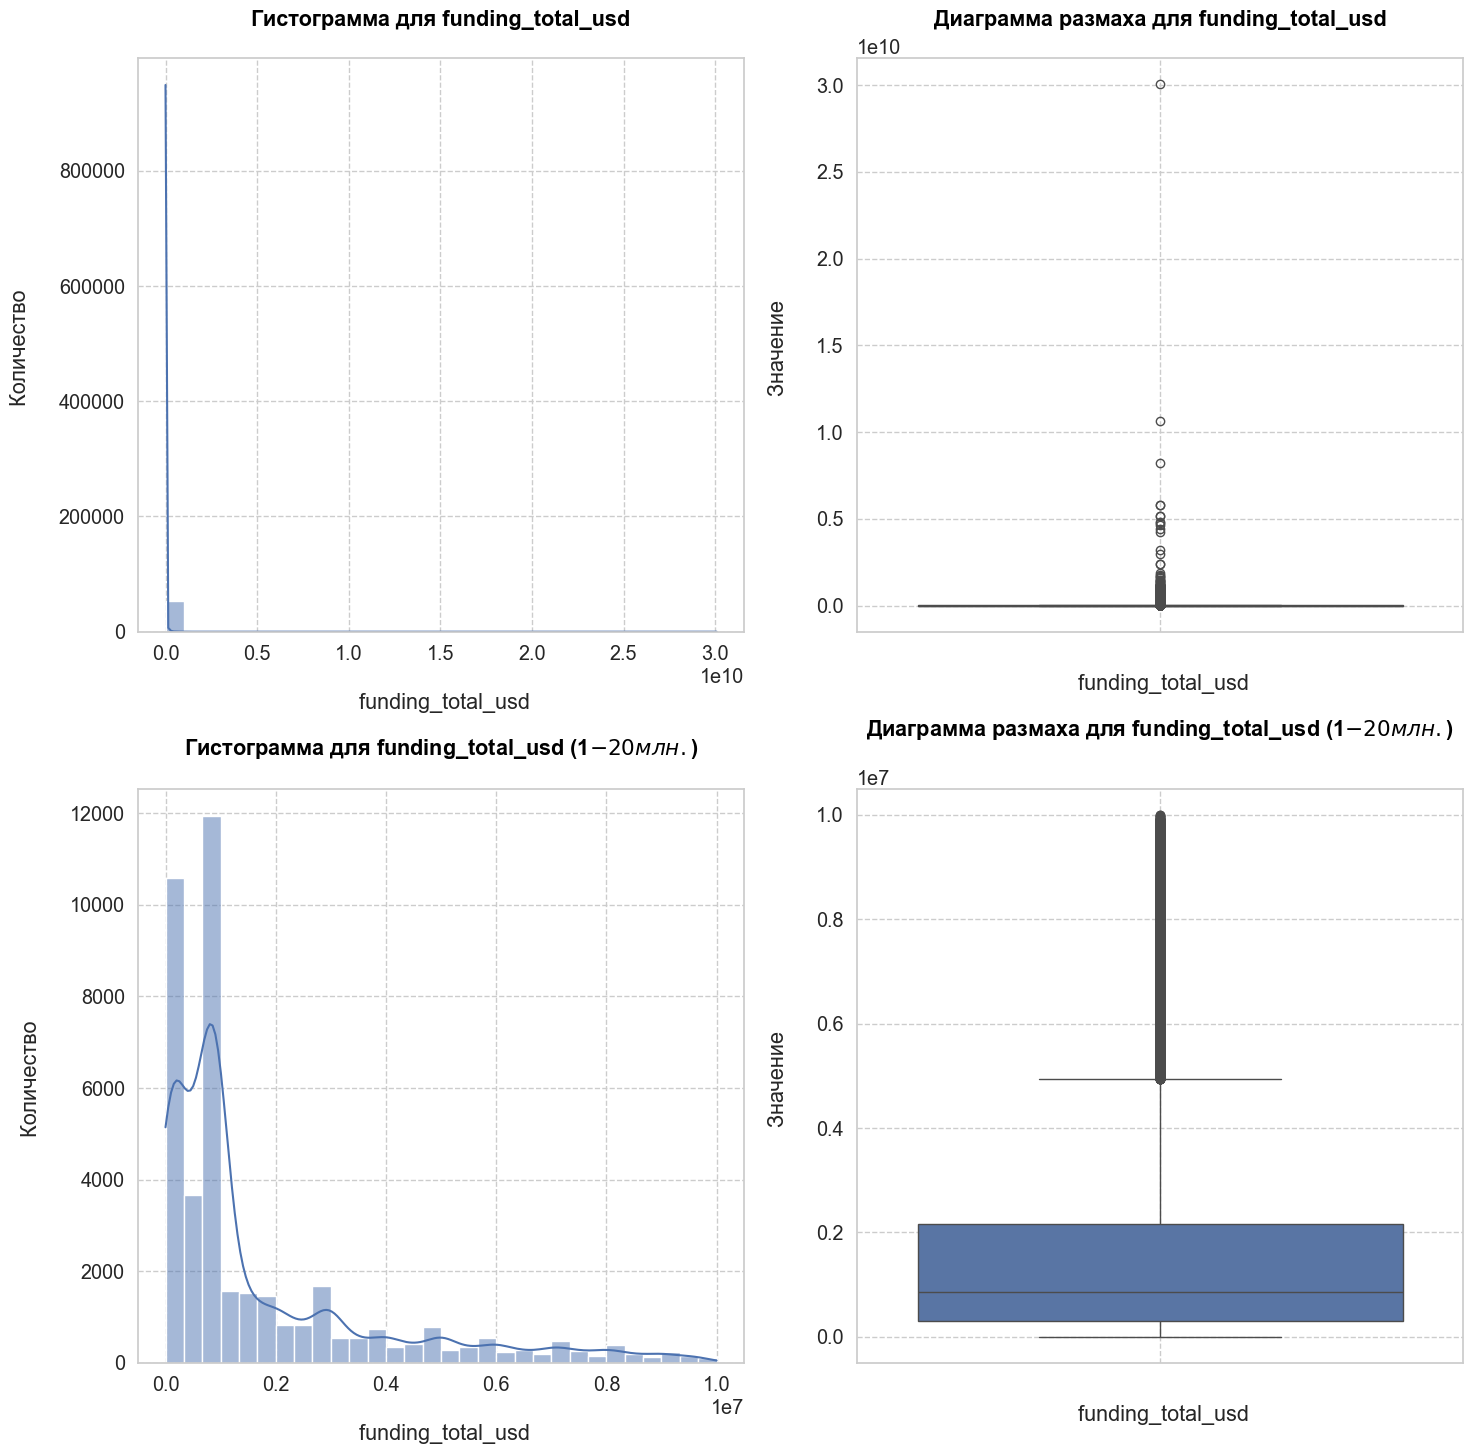

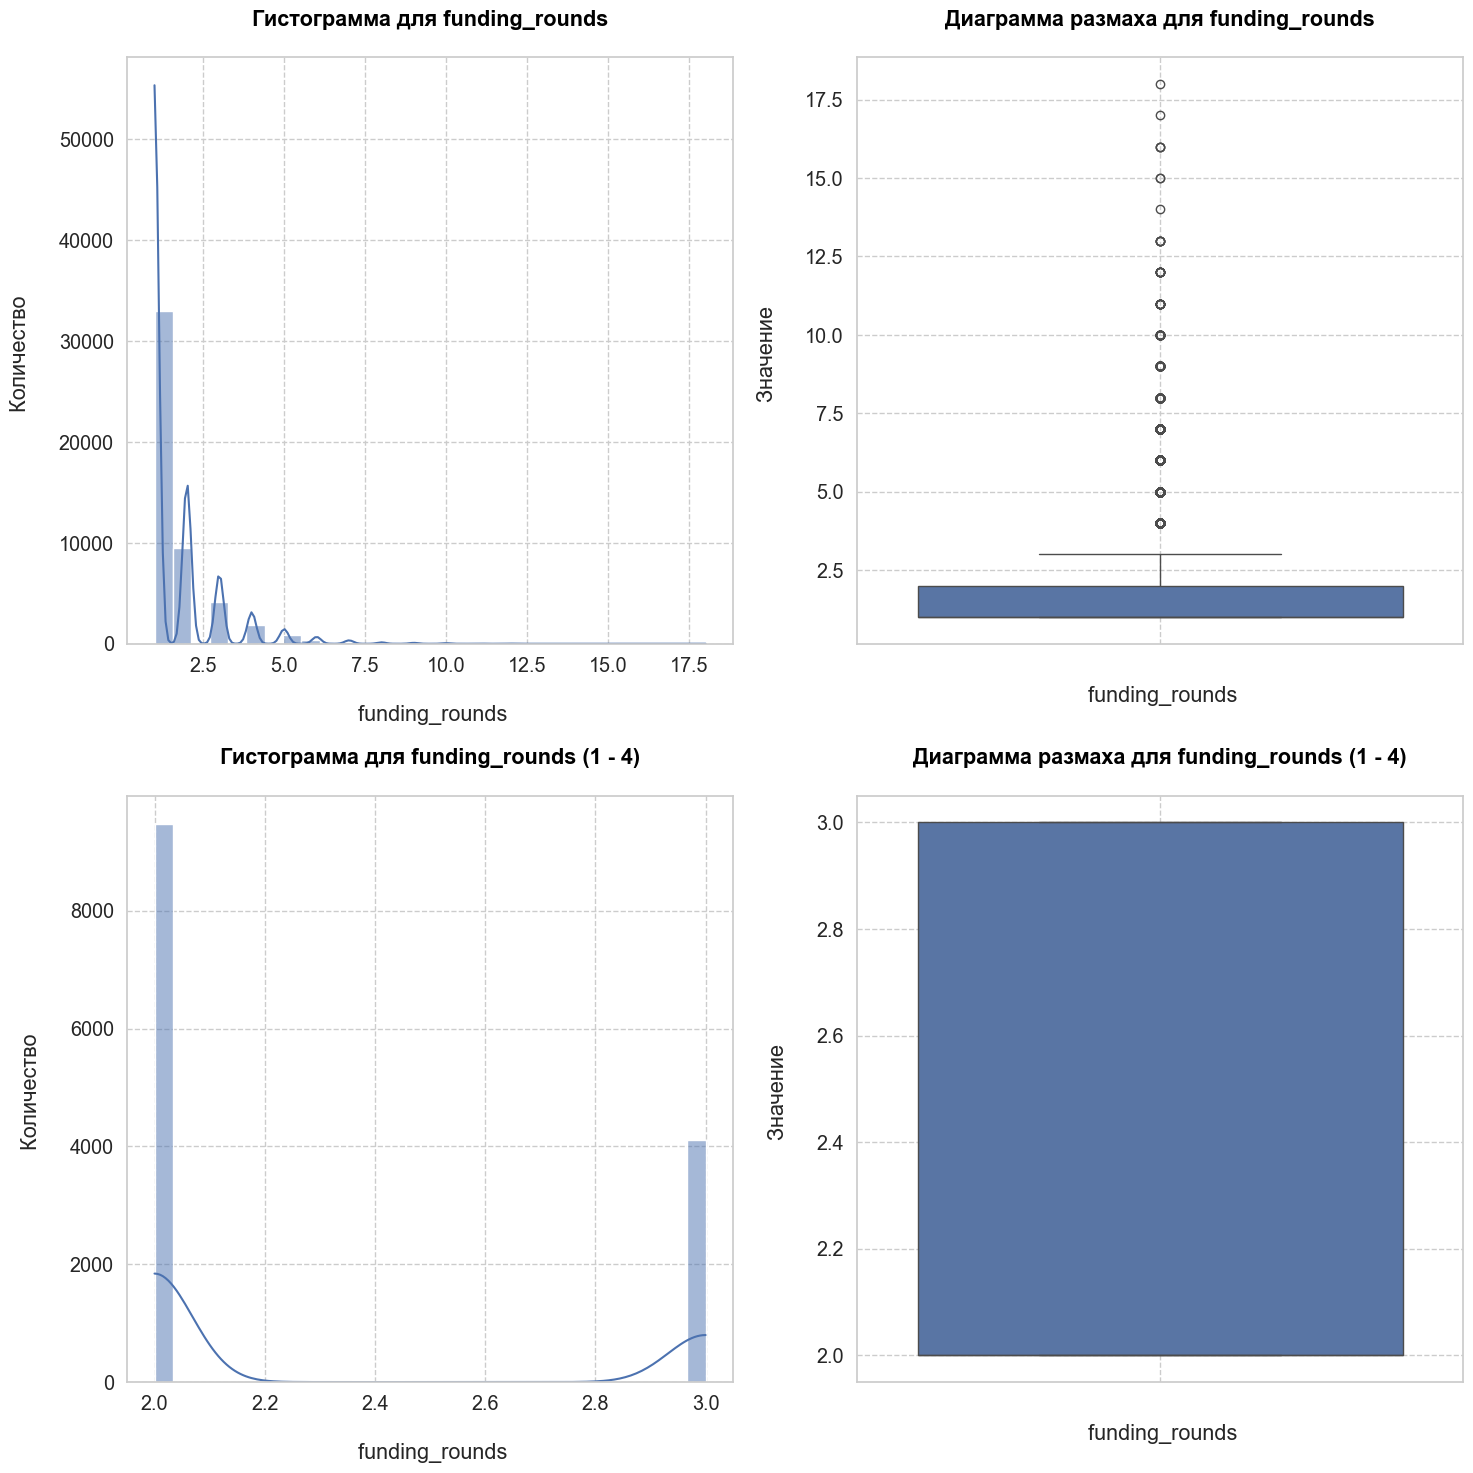

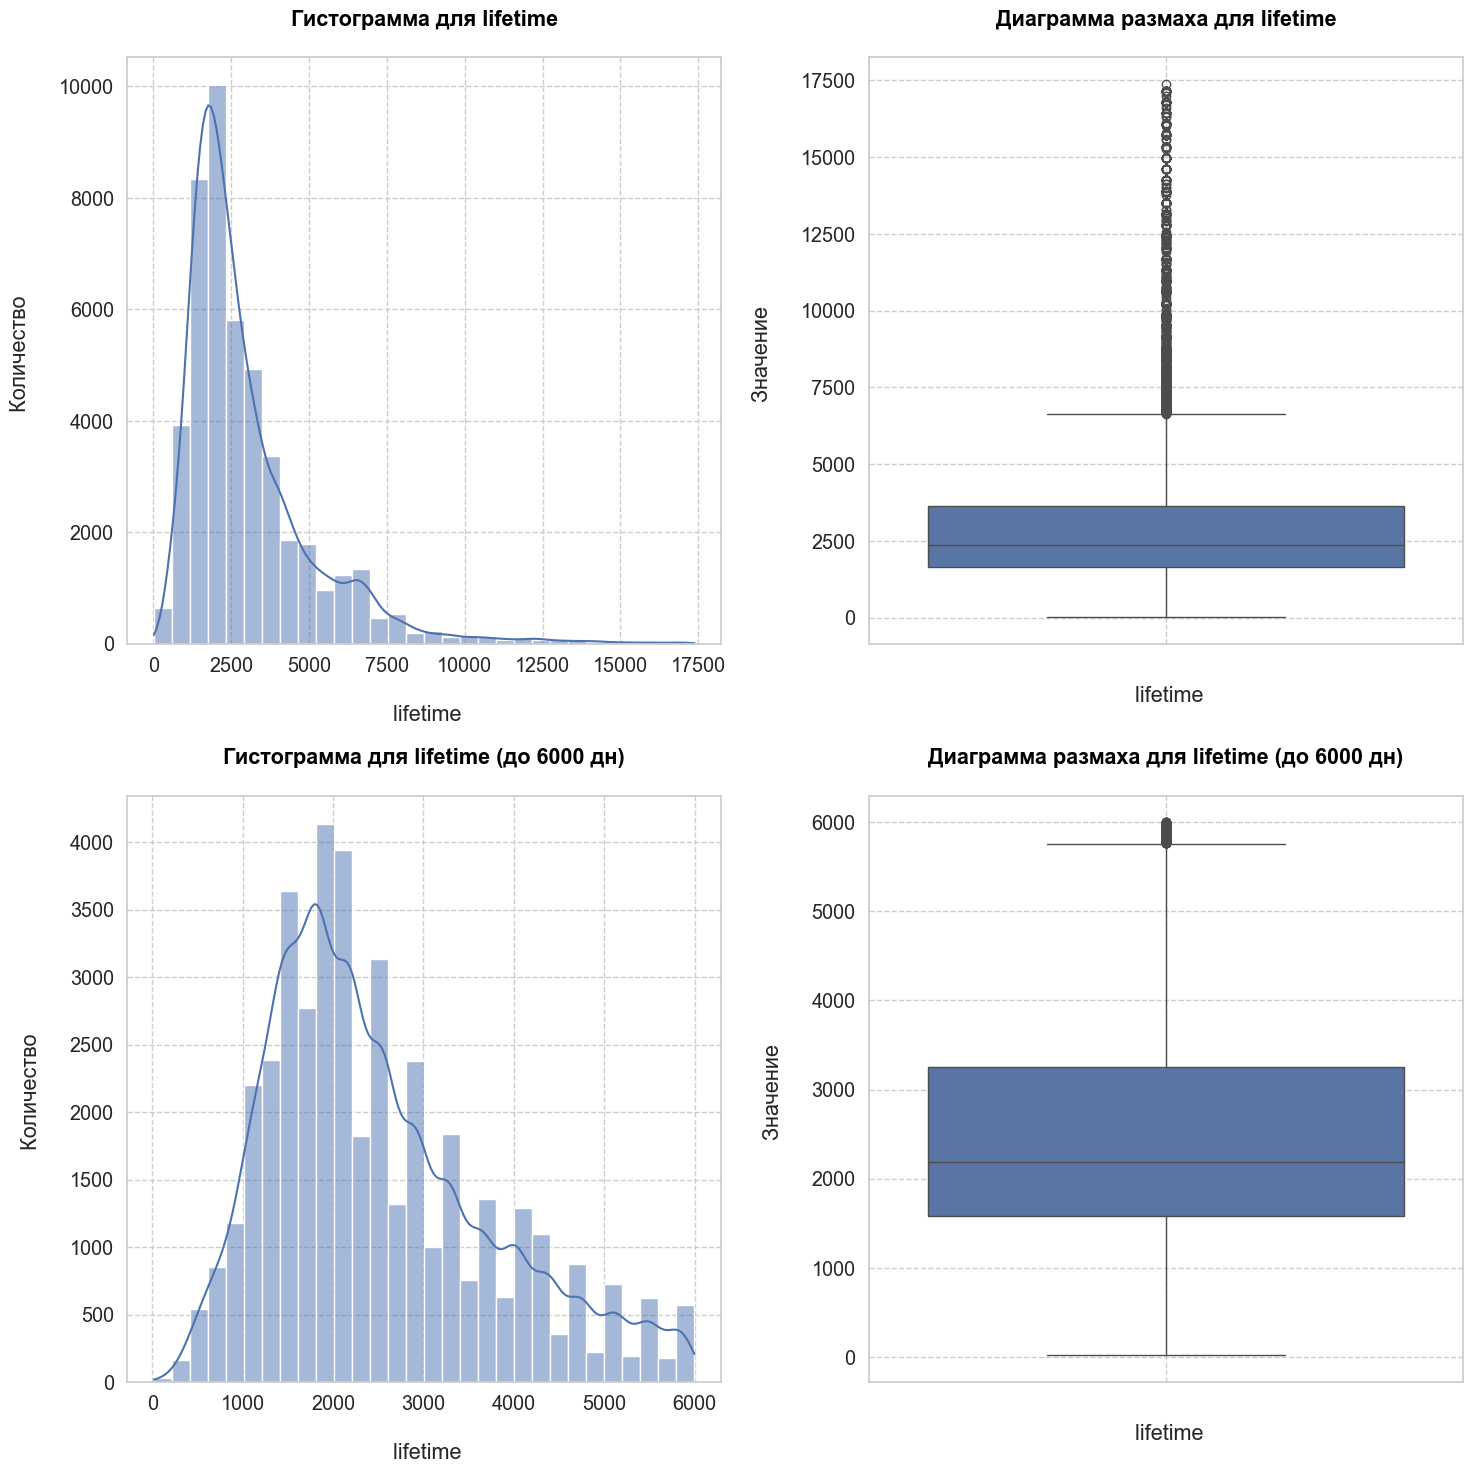

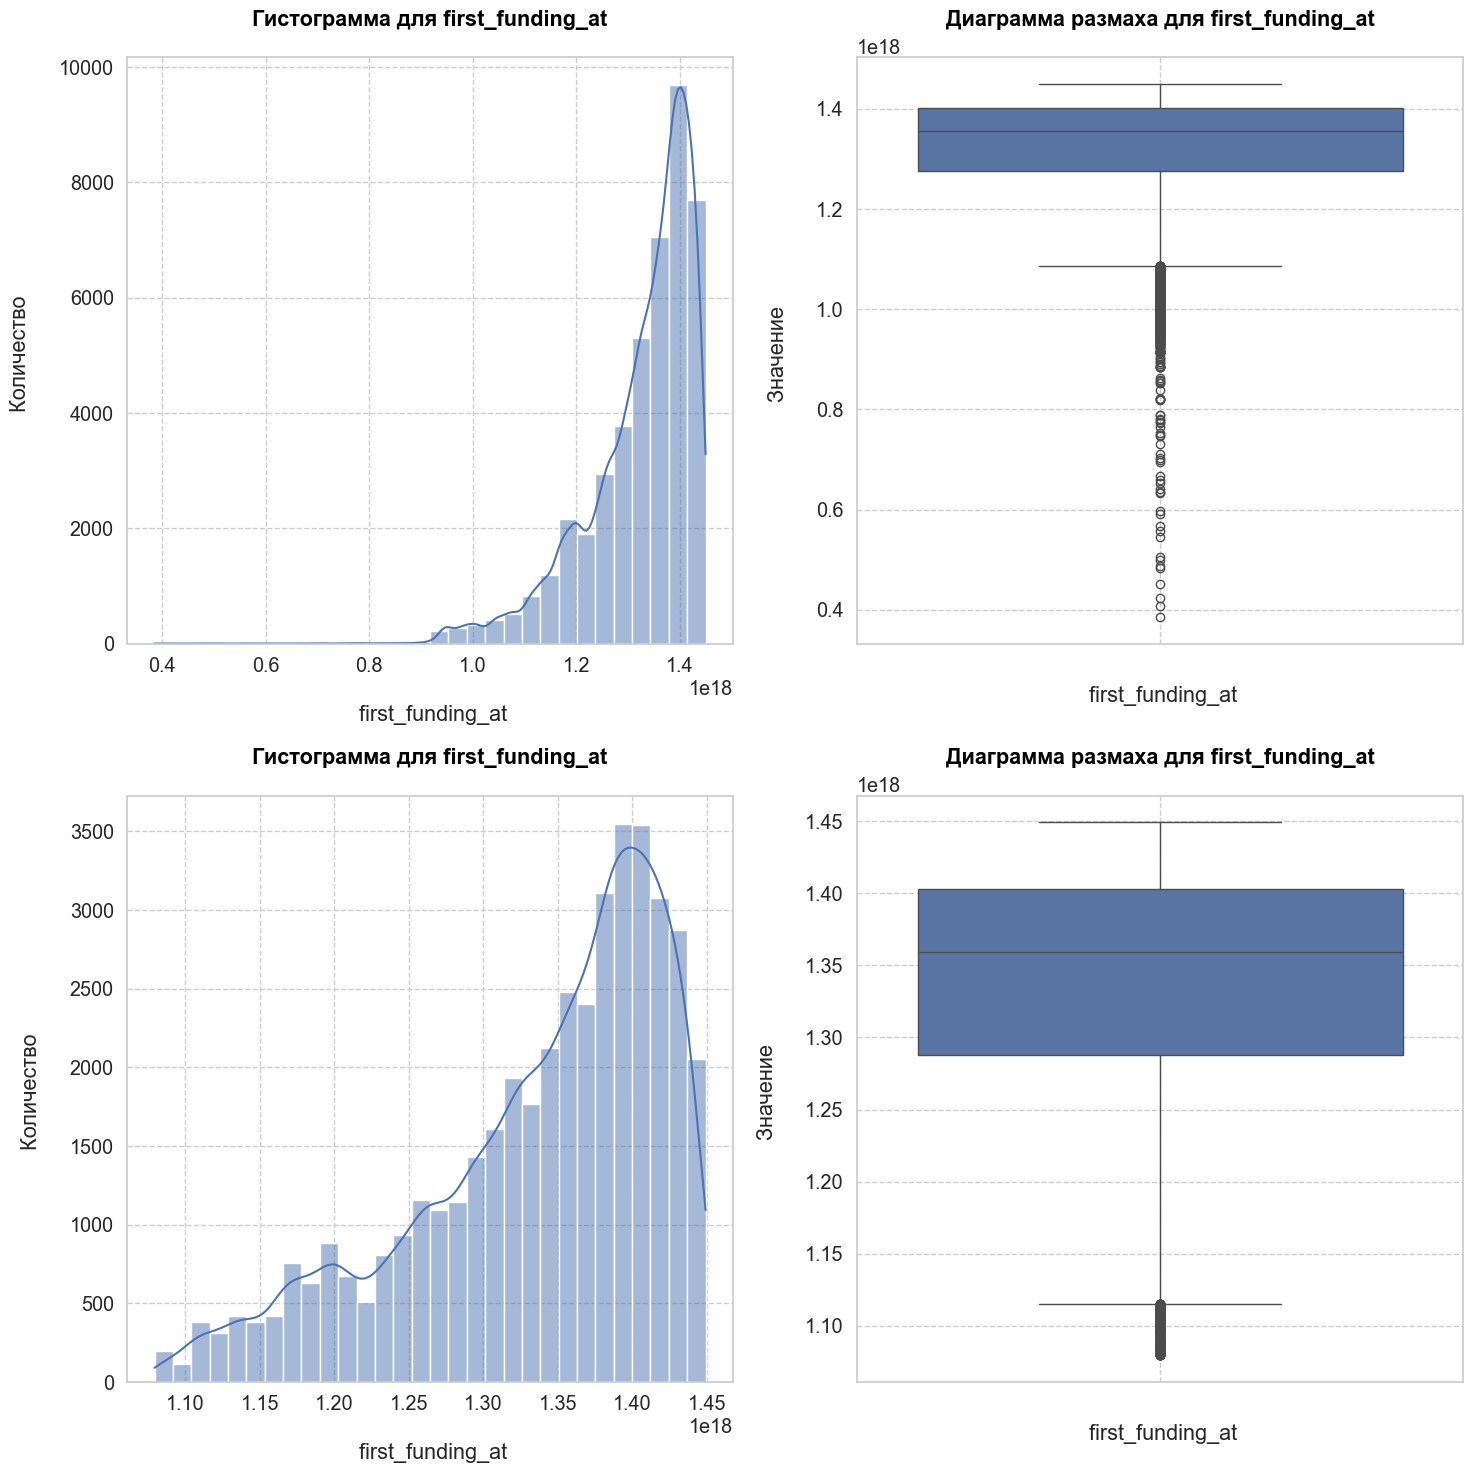

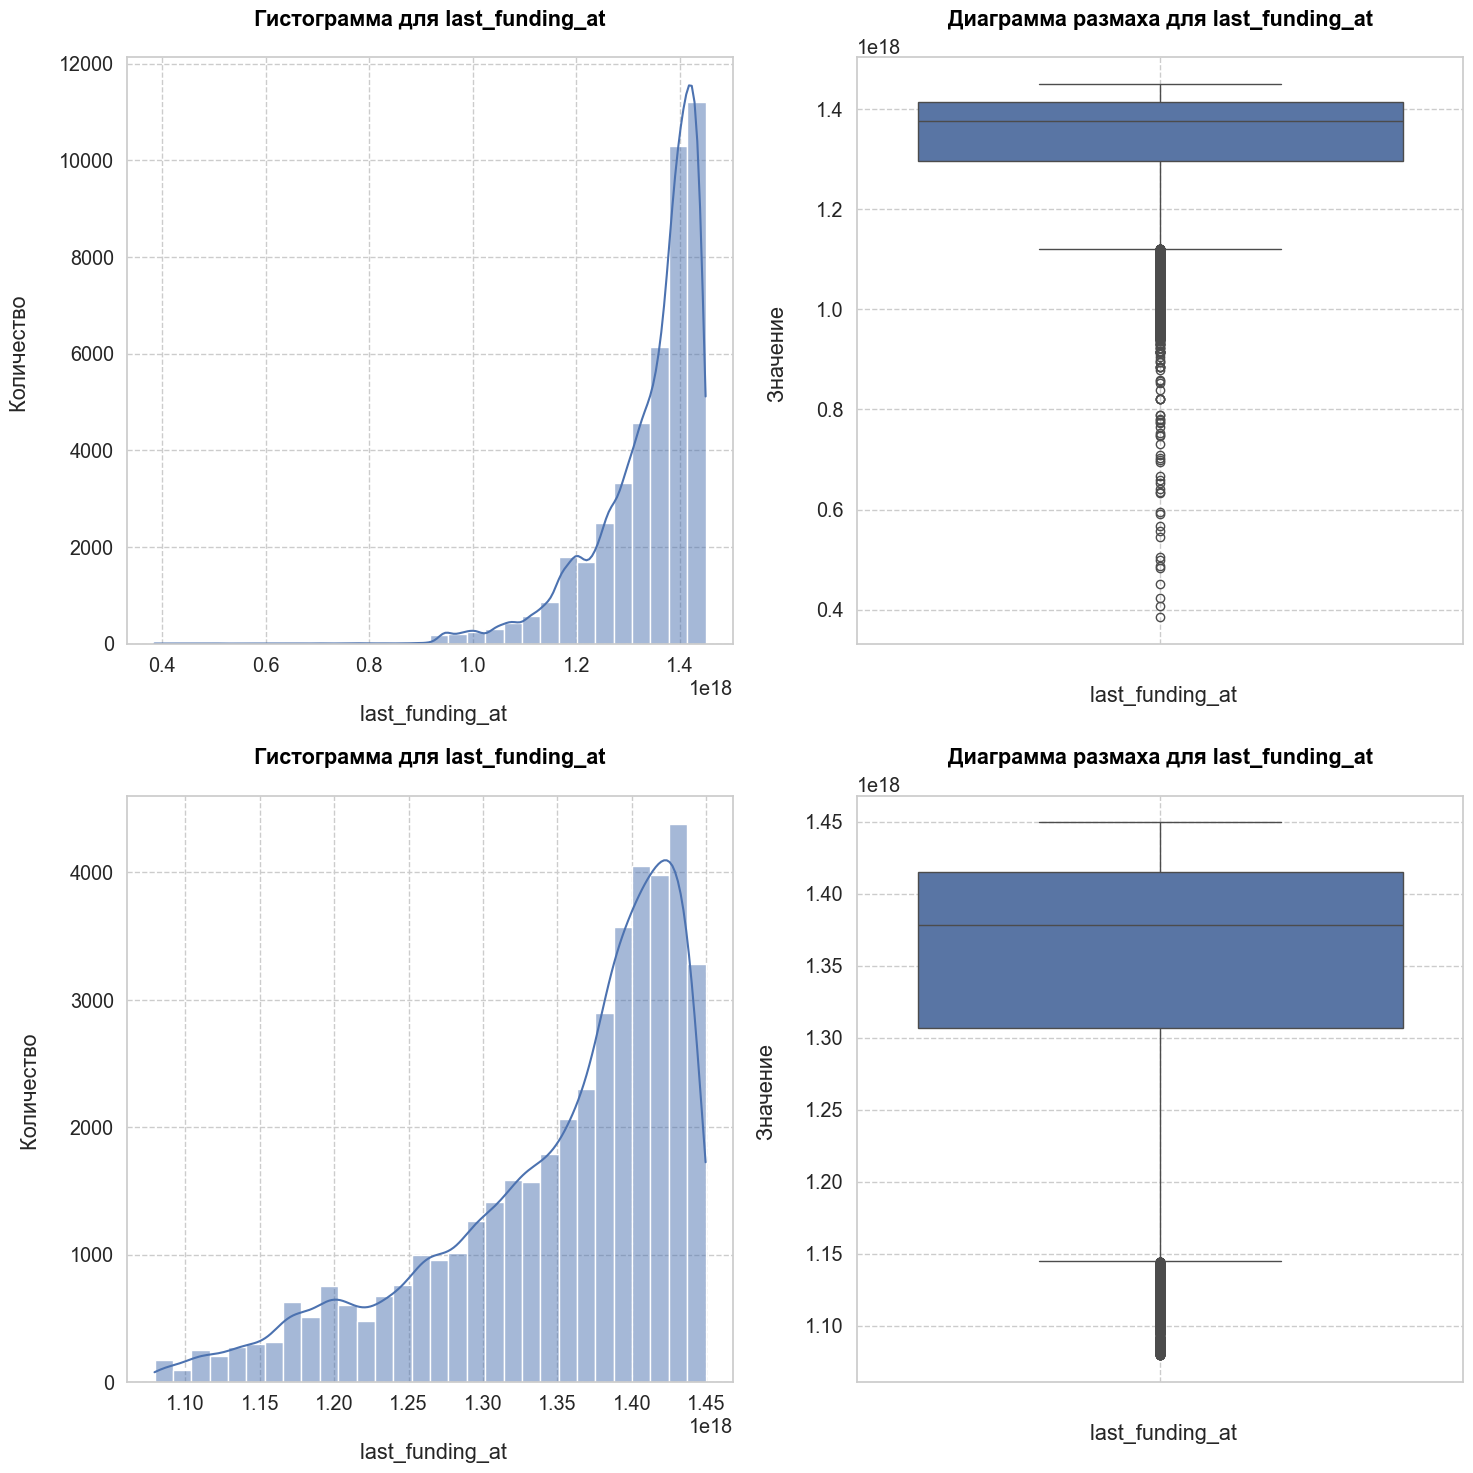

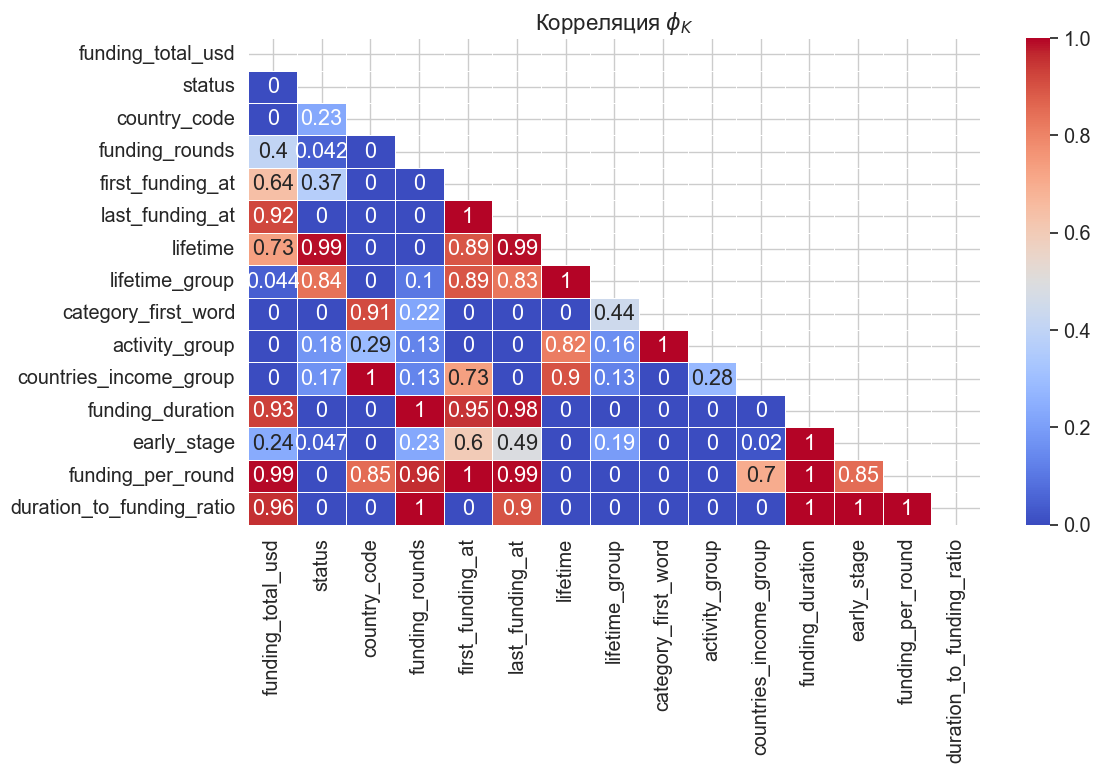

                      Feature  funding_total_usd    status  country_code  \
0           funding_total_usd           1.000000  0.000000      0.000000   
1                      status           0.000000  1.000000      0.228737   
2                country_code           0.000000  0.228737      1.000000   
3              funding_rounds           0.404168  0.042216      0.000000   
4            first_funding_at           0.641249  0.369976      0.000000   
5             last_funding_at           0.920361  0.000000      0.000000   
6                    lifetime           0.733323  0.989332      0.000000   
7              lifetime_group           0.044286  0.836956      0.000000   
8         category_first_word           0.000000  0.000000      0.910163   
9              activity_group           0.000000  0.175218      0.285987   
10     countries_income_group           0.000000  0.167287      1.000000   
11           funding_duration           0.932793  0.000000      0.000000   
12          

In [ ]:
# Список непрерывных признаков
interval_cols = ['funding_total_usd']

# Корреляционный анализ
check_corr = (
    df[0]
    .drop(columns=['name', 
                   'category_list', 
                   'state_code', 
                   'region', 
                   'city', 
                   'founded_at', 
                   'closed_at'])
    .sample(1000)
    .phik_matrix(interval_cols=interval_cols)
)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(12, 8))

# Маска для отображения нижнего треугольника
mask = np.triu(np.ones_like(check_corr, dtype=bool))
sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    mask=mask,
    ax=ax
)
ax.set_title(r'Корреляция $\phi_K$', fontsize=16)  # Использование сырой строки для корректного рендеринга LaTeX
plt.tight_layout()
plt.show()

# Преобразование корреляционной матрицы в таблицу для вывода
correlation_table = check_corr.reset_index()

# Переименовываем столбцы для удобства чтения
correlation_table.columns = ['Feature'] + list(check_corr.columns)

# Отображение таблицы в формате pandas
print(correlation_table)



### 3.3.2. Корреляционный анализ в разрезе действующих компаний

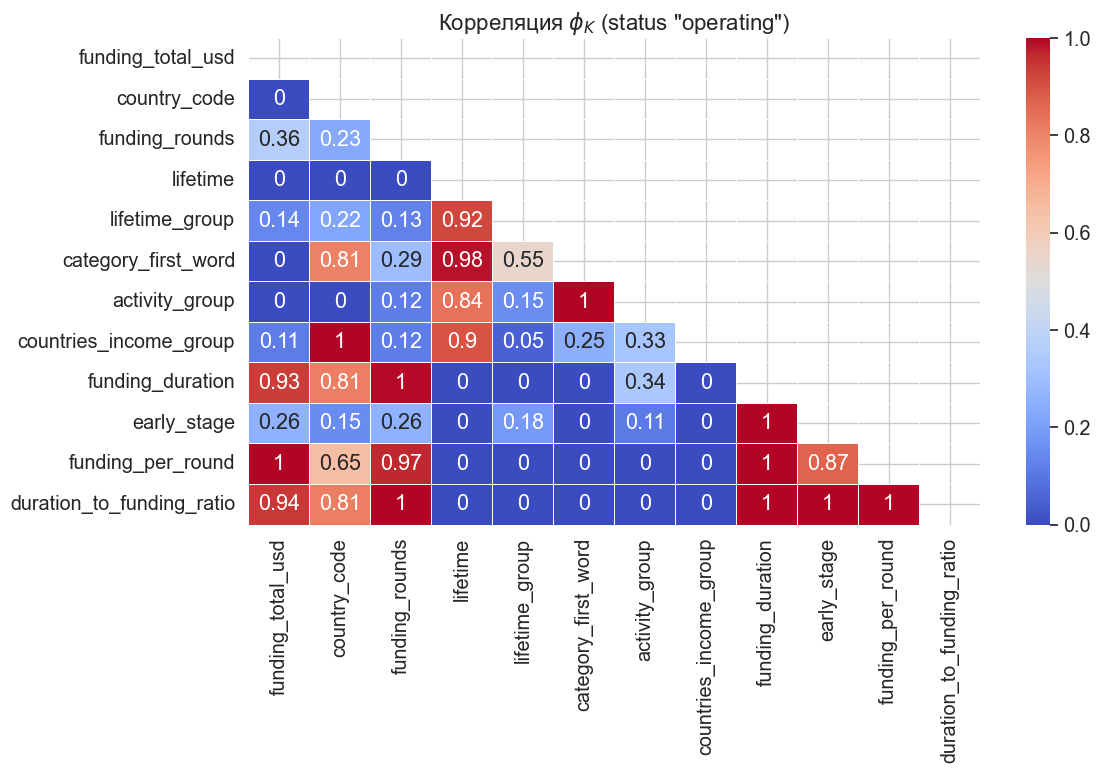

                      Feature  funding_total_usd  country_code  \
0           funding_total_usd           1.000000      0.000000   
1                country_code           0.000000      1.000000   
2              funding_rounds           0.363686      0.232681   
3                    lifetime           0.000000      0.000000   
4              lifetime_group           0.140558      0.222502   
5         category_first_word           0.000000      0.808248   
6              activity_group           0.000000      0.000000   
7      countries_income_group           0.111288      1.000000   
8            funding_duration           0.934090      0.812269   
9                 early_stage           0.258401      0.150343   
10          funding_per_round           0.997317      0.645808   
11  duration_to_funding_ratio           0.944385      0.810078   

    funding_rounds  lifetime  lifetime_group  category_first_word  \
0         0.363686  0.000000        0.140558             0.000000   
1  

In [ ]:
# Список непрерывных признаков
interval_cols = ['funding_total_usd']

# Корреляционный анализ
check_corr = (
    df[0]
    .query('status == "operating"') #в разрезе действующих компаний
    .drop(columns=['name',
                   'status',
                   'category_list',
                   'state_code',
                   'region', 
                   'city', 
                   'founded_at', 
                   'first_funding_at', 
                   'last_funding_at', 
                   'closed_at'])
    .sample(1000)
    .phik_matrix(interval_cols=interval_cols)
)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(12, 8))

# Маска для отображения нижнего треугольника
mask = np.triu(np.ones_like(check_corr, dtype=bool))
sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    mask=mask,
    ax=ax
)
ax.set_title(r'Корреляция $\phi_K$ (status "operating")', fontsize=16)  # Использование сырой строки для корректного рендеринга LaTeX
plt.tight_layout()
plt.show()

# Преобразование корреляционной матрицы в таблицу для вывода
correlation_table = check_corr.reset_index()

# Переименовываем столбцы для удобства чтения
correlation_table.columns = ['Feature'] + list(check_corr.columns)

# Отображение таблицы в формате pandas
print(correlation_table)


### 3.3.3 Корреляционный анализ в разрезе закрытых компаний

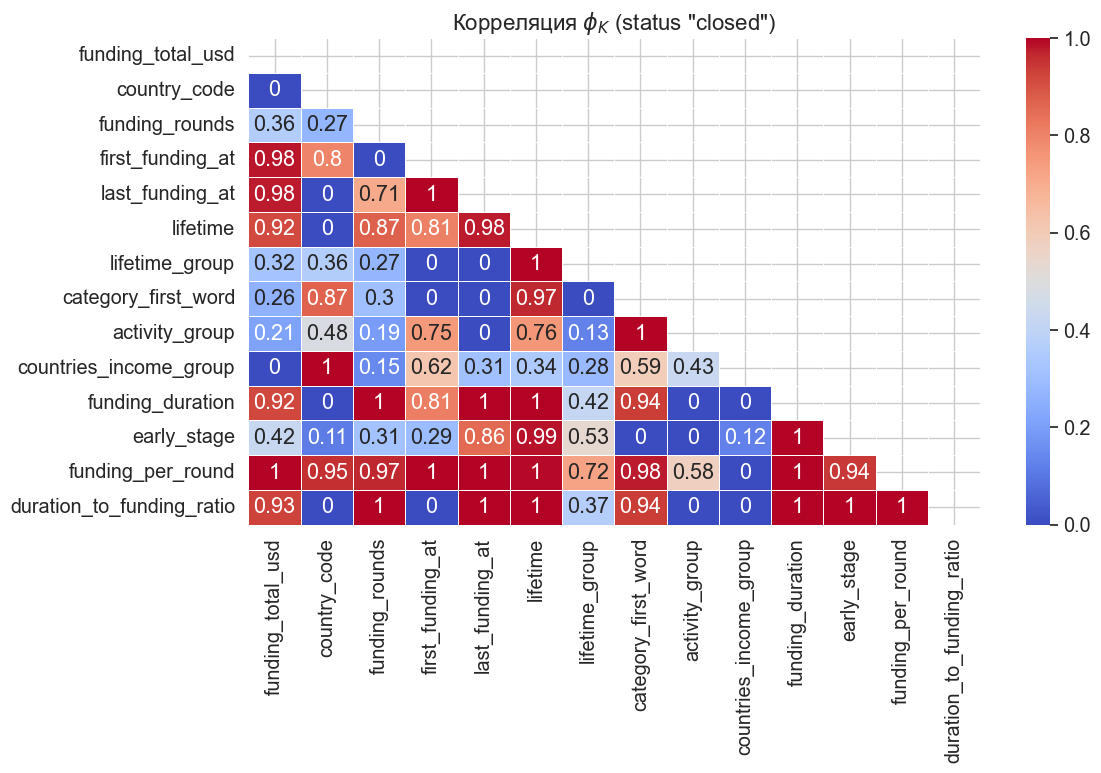

                      Feature  funding_total_usd  country_code  \
0           funding_total_usd           1.000000      0.000000   
1                country_code           0.000000      1.000000   
2              funding_rounds           0.361882      0.271179   
3            first_funding_at           0.984063      0.797018   
4             last_funding_at           0.979873      0.000000   
5                    lifetime           0.915459      0.000000   
6              lifetime_group           0.317471      0.360921   
7         category_first_word           0.261596      0.869353   
8              activity_group           0.211975      0.481148   
9      countries_income_group           0.000000      1.000000   
10           funding_duration           0.920635      0.000000   
11                early_stage           0.422661      0.110441   
12          funding_per_round           0.997361      0.953255   
13  duration_to_funding_ratio           0.927452      0.000000   

    fundi

In [ ]:
# Список непрерывных признаков
interval_cols = ['funding_total_usd']

# Корреляционный анализ
check_corr = (
    df[0]
    .query('status == "closed"') #в разрезе действующих компаний
    .drop(columns=['name',
                   'status',
                   'category_list',
                   'state_code',
                   'region', 
                   'city', 
                   'founded_at', 
                   'closed_at'])
    .sample(1000)
    .phik_matrix(interval_cols=interval_cols)
)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(12, 8))

# Маска для отображения нижнего треугольника
mask = np.triu(np.ones_like(check_corr, dtype=bool))
sns.heatmap(
    check_corr,
    annot=True,
    fmt='.2g',
    vmin=0,
    vmax=1,
    cmap='coolwarm',
    linewidths=0.5,
    mask=mask,
    ax=ax
)
ax.set_title(r'Корреляция $\phi_K$ (status "closed")', fontsize=16)  # Использование сырой строки для корректного рендеринга LaTeX
plt.tight_layout()
plt.show()

# Преобразование корреляционной матрицы в таблицу для вывода
correlation_table = check_corr.reset_index()

# Переименовываем столбцы для удобства чтения
correlation_table.columns = ['Feature'] + list(check_corr.columns)

# Отображение таблицы в формате pandas
print(correlation_table)


In [ ]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 44347 entries, 0 to 52515
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       44347 non-null  object        
 1   category_list              44347 non-null  object        
 2   funding_total_usd          44347 non-null  int64         
 3   status                     44347 non-null  object        
 4   country_code               44347 non-null  object        
 5   state_code                 44347 non-null  object        
 6   region                     44347 non-null  object        
 7   city                       44347 non-null  object        
 8   funding_rounds             44347 non-null  int64         
 9   founded_at                 44347 non-null  datetime64[ns]
 10  first_funding_at           44347 non-null  int64         
 11  last_funding_at            44347 non-null  int64         
 12  closed_at

### 3.3.4. Анализ зависимости целевого признака status от других признаков¶

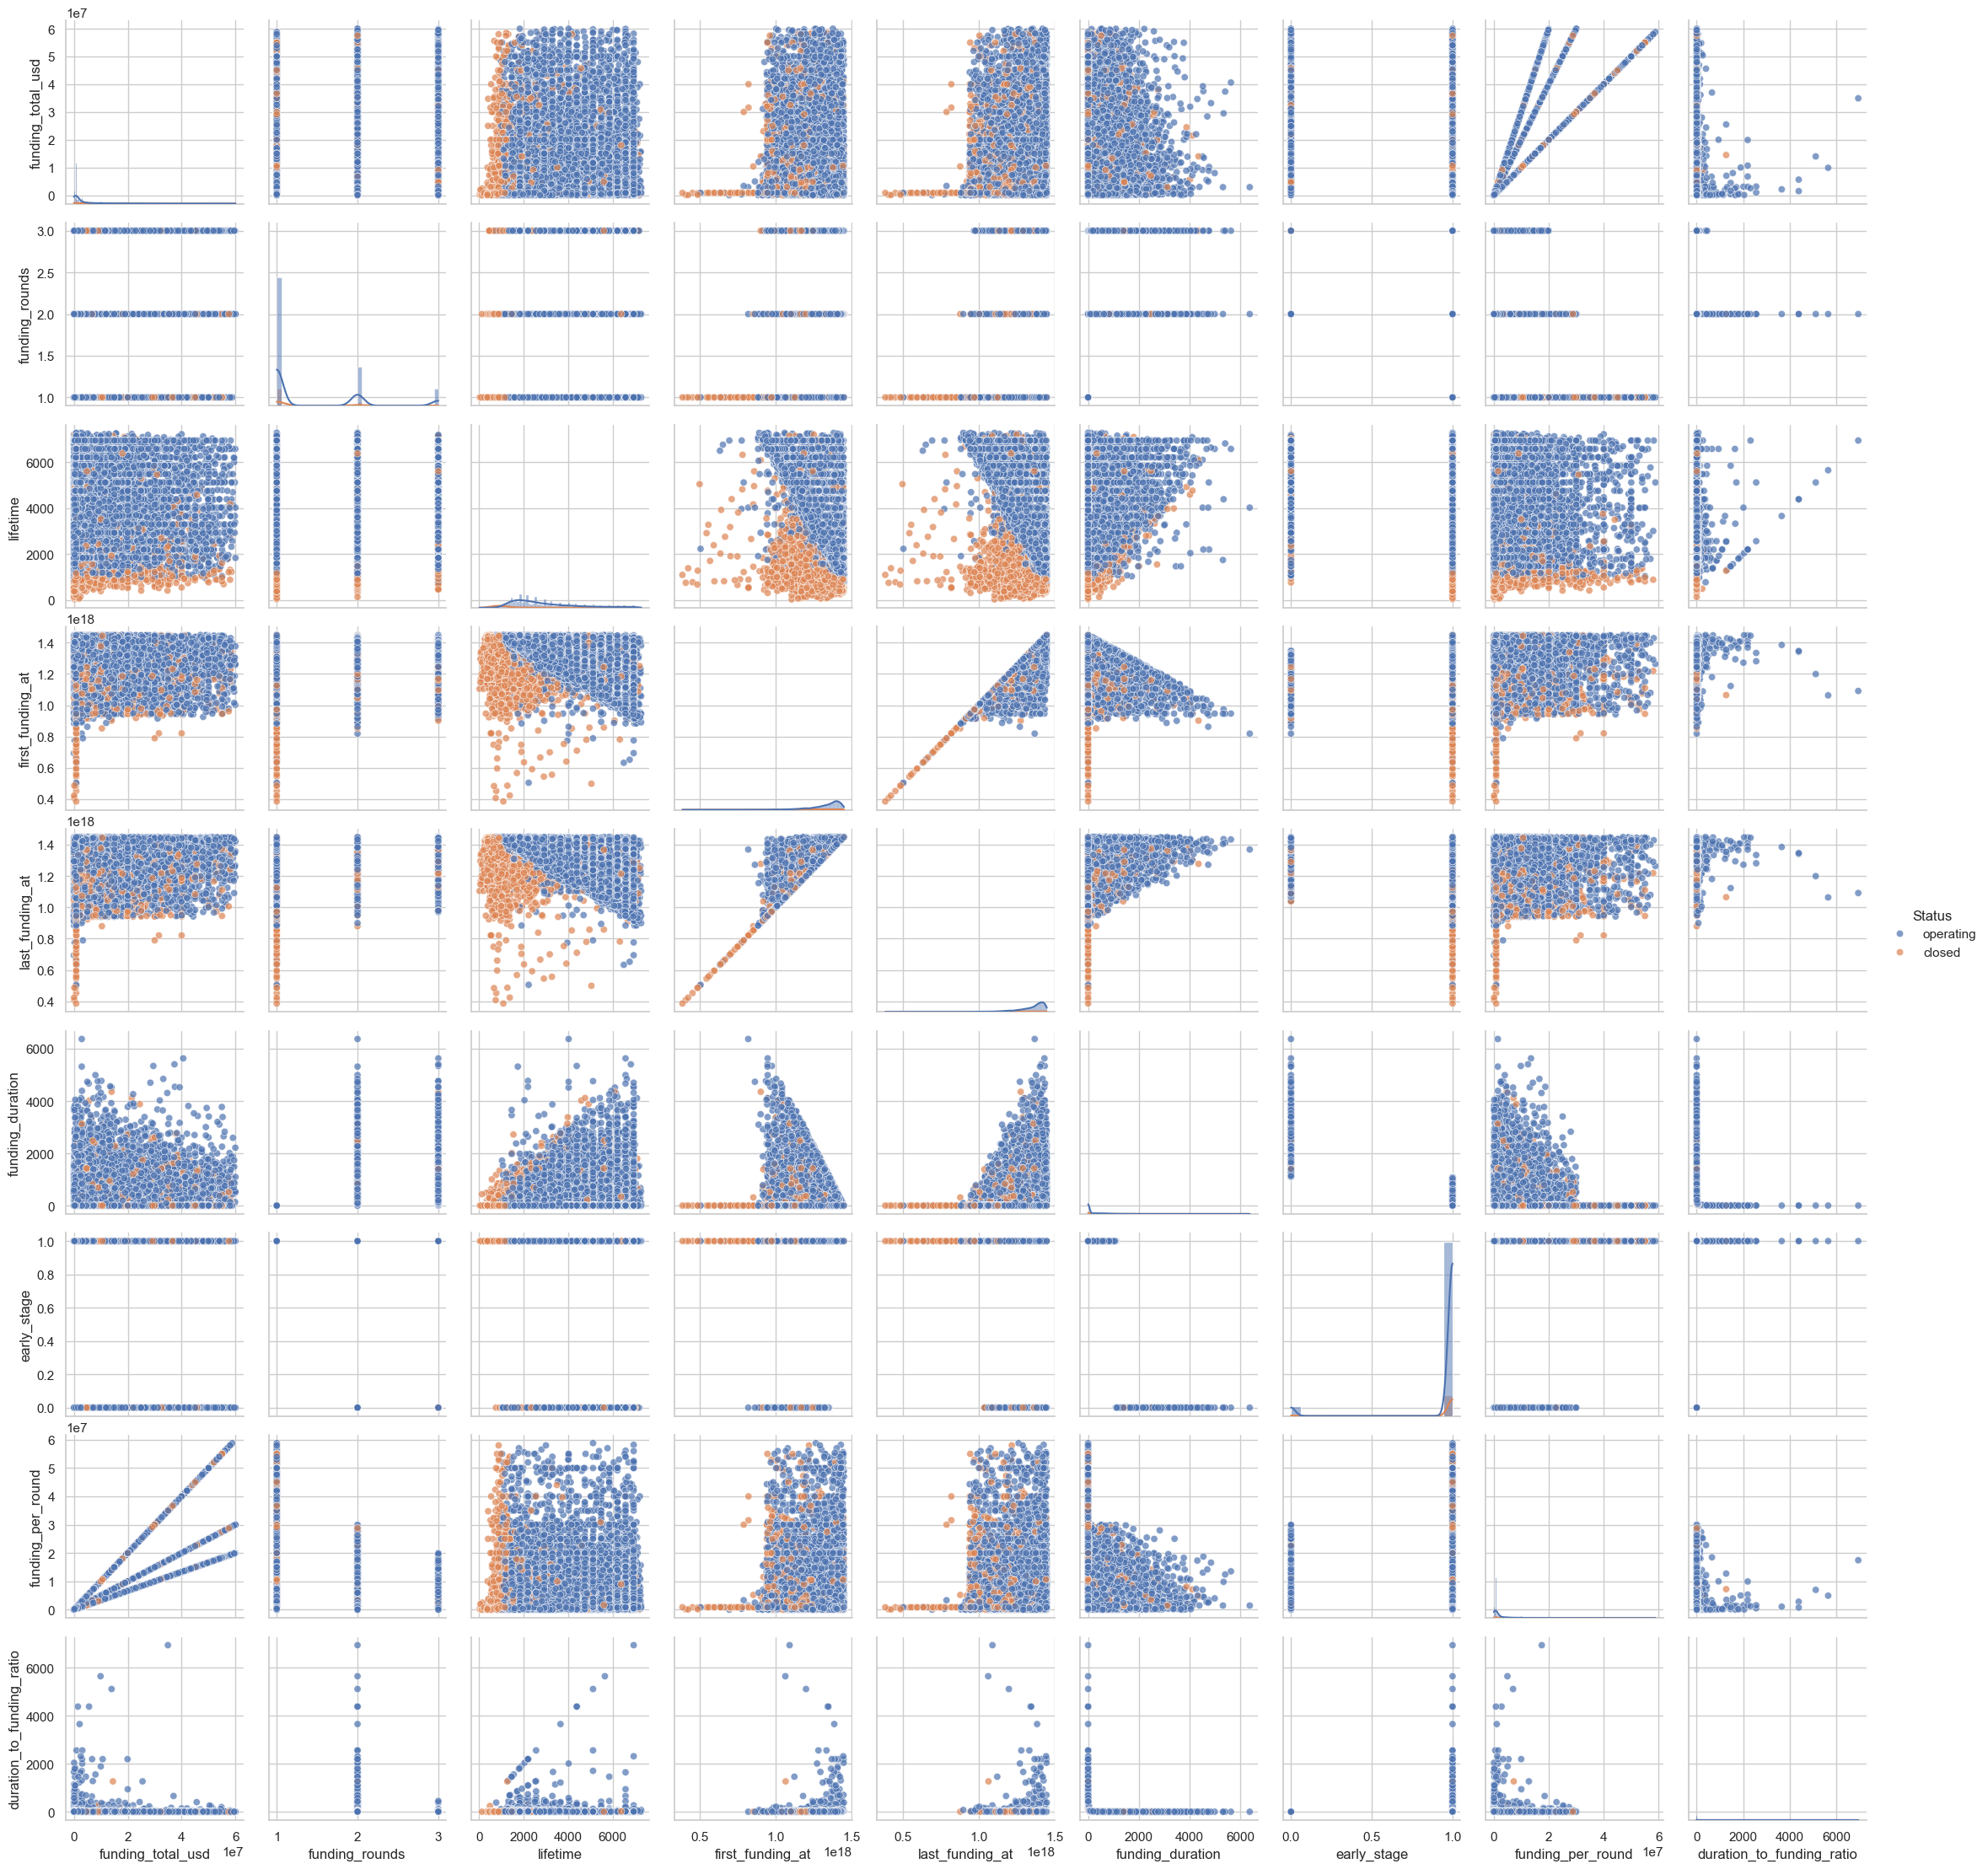

In [ ]:
# Выбор нужных колонок из DataFrame
columns_to_plot = [
    'funding_total_usd',
    'status',
    'funding_rounds',
    'lifetime',
    'first_funding_at',
    'last_funding_at',
    'funding_duration',
    'early_stage',
    'activity_group',
    'lifetime_group',
    'countries_income_group',
    'funding_per_round',
    'duration_to_funding_ratio'

    
]

# Создание PairGrid и настройка диаграмм
sns.set(style="whitegrid")  # Установка стиля для улучшения визуализации
pairgrid = sns.PairGrid(df[0][columns_to_plot], hue='status')
pairgrid.map_diag(sns.histplot, kde=True)  # Добавлено ядровое сглаживание
pairgrid.map_offdiag(sns.scatterplot, alpha=0.7)  # Установлен уровень прозрачности

# Добавление легенды и показ графика
pairgrid.add_legend(title="Status")
plt.show()


### Заключение по корреляционному анализу

**Обобщенное заключение и рекомендации по задаче машинного обучения**
**(Целевая задача — предсказание успешности стартапа: `status` = operating/closed)**  

---

**1. Анализ данных и выявленные зависимости**  

**Корреляционный анализ**  
**Действующие (`operating`) стартапы:**  
- `funding_total_usd` тесно связан с `funding_per_round` (0.998) и `funding_duration` (0.933). Это указывает на то, что успешные стартапы получают стабильное и распределенное финансирование в течение длительного времени.  
- `lifetime` имеет высокую корреляцию с `country_code` (0.96), что подчеркивает влияние региона на длительность работы стартапа.  
- `category_first_word` и `country_code` коррелируют (0.93), что говорит о специализации стартапов в зависимости от региона.  

**Закрытые (`closed`) стартапы:**  
- Для закрытых стартапов `funding_total_usd`, `funding_per_round` и `funding_duration` имеют очень высокую корреляцию (приближенную к 1), что указывает на ограниченный период получения финансирования перед закрытием.  
- `lifetime` сильно связан с `funding_rounds` (0.90) и `last_funding_at` (0.95). Закрытые стартапы часто прекращают работу вскоре после последнего раунда финансирования.  
- Взаимосвязь между `activity_group` и `category_first_word` (0.75) может указывать на то, что определенные сферы деятельности более подвержены риску закрытия.  

---

**Парные зависимости (`pairplot`)**  
- Явное различие между действующими и закрытыми стартапами наблюдается по следующим показателям:  
  - **`funding_total_usd`** – закрытые стартапы получают меньше общего финансирования.  
  - **`funding_rounds`** – действующие стартапы чаще проходят через большее количество раундов.  
  - **`lifetime`** – продолжительность работы стартапов напрямую связана с их статусом.  

---

**2. Особенности задачи машинного обучения**  
**Задача:**  
- Построить модель для предсказания успешности стартапа (продолжит ли он работу или закроется) на основе различных признаков.  
- **Целевая переменная** — `status` (`operating` или `closed`).  
- **Метрика для оптимизации** — **F1-score** (учитывает баланс между precision и recall).  

---

**3. Рекомендации по построению модели**  

**1. Обработка мультиколлинеарности** 
- Высокие корреляции между `funding_total_usd`, `funding_per_round`, `duration_to_funding_ratio` и `funding_duration` могут привести к переобучению.  
- **Решение:**  
  - Удалить или трансформировать высоко коррелирующие признаки (например, оставить `funding_total_usd` и исключить `funding_per_round`).  
  - Применить метод **PCA** или **SelectFromModel** для снижения размерности и выбора наиболее значимых признаков.  

**2. Создание новых признаков (`feature engineering`)**  
- Учитывая важность временных и финансовых факторов, рекомендуется добавить синтетические признаки:  
  - **`time_to_first_funding`** – разница между `founded_at` и `first_funding_at` (время до получения первого финансирования).  
  - **`funding_rate`** – отношение `funding_total_usd` к количеству раундов `funding_rounds` (эффективность привлеч


## Итоги по исследовательскому анализу данных

**Сделано:**
- Проведен исследовательский анализ признаков с помощью YData-profiling.
- Исключены выбросы из `df_train` (инвестиции > 60 млн долларов).
- Выполнен корреляционный анализ для тренировочного и тестового наборов данных.
- Построены корреляционные матрицы с разбивкой по статусу.
- Созданы диаграммы рассеяния числовых признаков с подсветкой данных по статусу.

**Выводы**

- **Ключевая роль признака `status`**:  
  Признак `status` (operating/closed) является основным целевым показателем успешности стартапов. Наибольшая корреляция наблюдается с:  
  - `lifetime_group` (0.666) — продолжительность жизни по категориям.  
  - `lifetime` (0.413) — продолжительность жизни в днях.  
  - `countries_income_group` (0.166) — уровень дохода страны.  
  - Финансирование (`funding_rounds`, `funding_total_usd`) имеет низкую корреляцию с `status`, что подчеркивает важность других факторов (категория стартапа, регион).  

- **Продолжительность существования (`lifetime` и `lifetime_group`)**:  
  Долгоживущие стартапы чаще успешны. Признак `lifetime_group` упрощает анализ через категории продолжительности.  

- **Финансирование (`funding_total_usd`, `funding_rounds`)**:  
  Объем финансирования и количество раундов умеренно связаны между собой, но слабо влияют на `status`. Большинство стартапов ограничиваются до 3 раундов и $10 млн.  

- **Региональные особенности (`countries_income_group`)**:  
  Стартапы из стран с высоким доходом (High income) составляют 81.7% выборки и имеют чуть большую вероятность успеха.  

- **Группы активности (`activity_group`)**:  
  Связь с успешным статусом минимальна (корреляция 0.162), но полезна для сегментации.  

---

**Рекомендации:**
1. **Подготовка данных для модели**:  
   - Кодировать категориальные признаки (`activity_group`, `countries_income_group`, `lifetime_group`).  
   - Применить логарифмическое преобразование к `funding_total_usd` для уменьшения влияния выбросов.  
   - Балансировать классы в `status` через oversampling или взвешивание.  

2. **Анализ ключевых зависимостей**:  
   - Учитывать сильные корреляции `lifetime` и `lifetime_group` с `status`.  
   - Включить региональные (`countries_income_group`) и отраслевые (`category_first_word`) признаки в модели.  

3. **Обработка мультиколлинеарности**:  
   - Использовать регуляризацию (Ridge, Lasso) для снижения влияния коррелирующих признаков.  

---

**Итог**:  
Признак `status` требует фокусировки на переменных, связанных с продолжительностью жизни (`lifetime`), финансированием и региональными особенностями. Правильная подготовка данных и устранение выбросов улучшат качество моделей и позволят выделить ключевые закономерности успешности стартапов.


# 4. Построение модели машинного обучения с использованием пайплайнов

## 4.1. Подготовка данных для ML

In [69]:
#Сравним столбцы в датасетах
# Получаем список всех столбцов
all_columns = set(df[0].columns).union(set(df[1].columns))

# Создаем сводную таблицу
summary = []
for column in all_columns:
    row = {
        'Column': column,
        'In_df[0]': column in df[0].columns,
        'Type_in_df[0]': df[0][column].dtype if column in df[0].columns else None,
        'In_df[1]': column in df[1].columns,
        'Type_in_df[1]': df[1][column].dtype if column in df[1].columns else None
    }
    summary.append(row)

# Преобразуем список в датафрейм
summary_df = pd.DataFrame(summary)

# Отображаем таблицу в Jupyter Notebook
display(summary_df)

# Получаем список одинаковых столбцов
common_columns = set(df[0].columns).intersection(set(df[1].columns))

# Выводим список
common_columns_list = list(common_columns)
common_columns_list

Column  In_df[0]   Type_in_df[0]  In_df[1]  \
0           funding_per_round      True         float64      True   
1               category_list      True          object      True   
2   duration_to_funding_ratio      True         float64      True   
3            funding_duration      True           int64      True   
4                      status      True          object     False   
5                        name      True          object      True   
6                   closed_at      True  datetime64[ns]     False   
7                country_code      True          object      True   
8              activity_group      True          object      True   
9              lifetime_group      True        category      True   
10                     region      True          object      True   
11        category_first_word      True          object      True   
12                 founded_at      True  datetime64[ns]     False   
13             funding_rounds      True           int64      True   
14                       city      True          object      True   
15                early_stage      True           int32      True   
16                 state_code      True          object      True   
17          funding_total_usd      True           int64      True   
18            last_funding_at      True           int64      True   
19           first_funding_at      True           int64      True   
20                   lifetime      True           int64      True   
21     countries_income_group      True          object      True   

     Type_in_df[1]  
0          float64  
1           object  
2          float64  
3            int64  
4             None  
5           object  
6             None  
7           object  
8           object  
9         category  
10          object  
11          object  
12            None  
13           int64  
14          object  
15           int32  
16          object  
17         float64  
18  datetime64[ns]  
19  datetime64[ns]  
20           int64  
21          object

['funding_per_round',
 'duration_to_funding_ratio',
 'category_list',
 'funding_duration',
 'name',
 'country_code',
 'activity_group',
 'lifetime_group',
 'region',
 'category_first_word',
 'funding_rounds',
 'city',
 'early_stage',
 'state_code',
 'funding_total_usd',
 'last_funding_at',
 'first_funding_at',
 'lifetime',
 'countries_income_group']

## Создадим датасет для обучения модели

Для создания данного датасета возьмем превоночальный тренеровочный датасет объеденим его с предобработанным датасетом оставив только те строки которые прошли предобработку (выбросы), добавим синтетические признаки и в них вернем попуски

In [70]:
df_train = pd.read_csv('datasets/kaggle_startups_train_28062024.csv', sep=sep, decimal=decimal)
df_train.info()
df[0].info()

In [73]:
# Выберем признаки для объединения
df_train_selected = df_train[['name','status','funding_total_usd', 'funding_rounds']]
df_0_selected = df[0][[
    'name', 
    'lifetime',
    'lifetime_group', 
    'activity_group', 
    'countries_income_group',
    'first_funding_at',
    'last_funding_at',
    'category_first_word',
    'funding_duration',
    'early_stage',
    'funding_per_round',
    'duration_to_funding_ratio'  
    
    
    ]]

In [74]:
#Объединяем по  'name'
merged_df = pd.merge(df_train_selected, df_0_selected, on='name', how='inner')

In [ ]:
# Почистим предобработанные синтетические столбы ввернув пустые столбцы
merged_df['activity_group'] = merged_df['activity_group'].replace('NO_CATEGORY', np.nan)
merged_df['activity_group'].unique()

array(['J', 'C', 'Q', nan, 'N', 'S', 'P', 'K', 'R', 'M', 'G', 'L', 'F',
       'D', 'H', 'I', 'O', 'E', 'A', 'B'], dtype=object)

In [ ]:
merged_df['countries_income_group'] = merged_df['countries_income_group'].replace('NO_COUNTRY', np.nan)
merged_df['countries_income_group'].unique()

array(['High income', nan, 'Lower middle income', 'Upper middle income',
       'Low income'], dtype=object)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44346 entries, 0 to 44345
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       44346 non-null  object  
 1   status                     44346 non-null  object  
 2   funding_total_usd          34821 non-null  float64 
 3   funding_rounds             44346 non-null  int64   
 4   lifetime                   44346 non-null  int64   
 5   lifetime_group             44346 non-null  category
 6   activity_group             42038 non-null  object  
 7   countries_income_group     39155 non-null  object  
 8   first_funding_at           44346 non-null  int64   
 9   last_funding_at            44346 non-null  int64   
 10  category_first_word        44346 non-null  object  
 11  funding_duration           44346 non-null  int64   
 12  early_stage                44346 non-null  int32   
 13  funding_per_round          4434

#_______________________________________________________________________

In [ ]:
df[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       13125 non-null  object        
 1   category_list              13125 non-null  object        
 2   funding_total_usd          13125 non-null  float64       
 3   country_code               13125 non-null  object        
 4   state_code                 13125 non-null  object        
 5   region                     13125 non-null  object        
 6   city                       13125 non-null  object        
 7   funding_rounds             13125 non-null  int64         
 8   first_funding_at           13125 non-null  datetime64[ns]
 9   last_funding_at            13125 non-null  datetime64[ns]
 10  lifetime                   13125 non-null  int64         
 11  lifetime_group             13125 non-null  category      
 12  cate

In [79]:
#Обработаем также тестовый датасет
df_test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv', sep=sep, decimal=decimal)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [81]:
#Меняем тип данных на int64
df[1]['first_funding_at'] = df[1]['first_funding_at'].astype("int64")
df[1]['last_funding_at'] = df[1]['last_funding_at'].astype("int64")

In [82]:
df_test_selected = df_test[['name','funding_total_usd', 'funding_rounds']]
df_1_selected = df[1][[
    'name', 
    'lifetime',
    'lifetime_group', 
    'activity_group', 
    'countries_income_group',
    'first_funding_at',
    'last_funding_at',
    'category_first_word',
    'funding_duration',
    'early_stage',
    'funding_per_round',
    'duration_to_funding_ratio'  
    
    
    ]]



# Merging datasets on the 'name' column
merged_df_test = pd.merge(df_test_selected, df_1_selected, on='name', how='inner')

In [83]:
merged_df_test['activity_group'] = merged_df_test['activity_group'].replace('NO_CATEGORY', np.nan)
merged_df_test['activity_group'].unique()

array(['C', 'I', 'K', 'J', 'M', 'Q', 'N', 'P', 'S', 'R', 'G', nan, 'L',
       'F', 'H', 'D', 'O', 'A', 'E', 'B'], dtype=object)

In [84]:
merged_df_test['countries_income_group'].unique()

array(['Lower middle income', 'High income', 'NO_COUNTRY',
       'Upper middle income', 'Low income'], dtype=object)

In [85]:
merged_df_test['countries_income_group'] = merged_df['countries_income_group'].replace('NO_COUNTRY', np.nan)
merged_df_test['countries_income_group'].unique()

array(['High income', nan, 'Lower middle income', 'Upper middle income',
       'Low income'], dtype=object)

In [86]:
merged_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       13125 non-null  object  
 1   funding_total_usd          10547 non-null  float64 
 2   funding_rounds             13125 non-null  int64   
 3   lifetime                   13125 non-null  int64   
 4   lifetime_group             13125 non-null  category
 5   activity_group             12534 non-null  object  
 6   countries_income_group     11566 non-null  object  
 7   first_funding_at           13125 non-null  int64   
 8   last_funding_at            13125 non-null  int64   
 9   category_first_word        13125 non-null  object  
 10  funding_duration           13125 non-null  int64   
 11  early_stage                13125 non-null  int32   
 12  funding_per_round          13125 non-null  float64 
 13  duration_to_funding_ratio  1312

In [87]:
#Сравним столбцы в датасетах
# Получаем список всех столбцов
all_columns = set(merged_df.columns).union(set(merged_df_test.columns))

# Создаем сводную таблицу
summary = []
for column in all_columns:
    row = {
        'Column': column,
        'In_merged_df': column in merged_df.columns,
        'Type_in_merged_df': merged_df[column].dtype if column in merged_df.columns else None,
        'In_merged_df_test': column in merged_df_test.columns,
        'Type_in_merged_df_test': merged_df_test[column].dtype if column in merged_df_test.columns else None
    }
    summary.append(row)

# Преобразуем список в датафрейм
summary_df = pd.DataFrame(summary)

# Отображаем таблицу в Jupyter Notebook
display(summary_df)

# Получаем список одинаковых столбцов
common_columns = set(merged_df.columns).intersection(set(merged_df_test.columns))

# Выводим список
common_columns_list = list(common_columns)
common_columns_list

Column  In_merged_df Type_in_merged_df  \
0              lifetime_group          True          category   
1         category_first_word          True            object   
2           funding_per_round          True           float64   
3   duration_to_funding_ratio          True           float64   
4            funding_duration          True             int64   
5              funding_rounds          True             int64   
6                      status          True            object   
7                 early_stage          True             int32   
8                        name          True            object   
9           funding_total_usd          True           float64   
10            last_funding_at          True             int64   
11           first_funding_at          True             int64   
12                   lifetime          True             int64   
13     countries_income_group          True            object   
14             activity_group          True            object   

    In_merged_df_test Type_in_merged_df_test  
0                True               category  
1                True                 object  
2                True                float64  
3                True                float64  
4                True                  int64  
5                True                  int64  
6               False                   None  
7                True                  int32  
8                True                 object  
9                True                float64  
10               True                  int64  
11               True                  int64  
12               True                  int64  
13               True                 object  
14               True                 object

['lifetime_group',
 'category_first_word',
 'funding_per_round',
 'name',
 'duration_to_funding_ratio',
 'funding_total_usd',
 'funding_duration',
 'last_funding_at',
 'funding_rounds',
 'first_funding_at',
 'lifetime',
 'countries_income_group',
 'activity_group',
 'early_stage']

In [88]:
merged_df['duration_to_funding_ratio'].unique()

# Проверяем на inf и NaN
print(np.isinf(merged_df['duration_to_funding_ratio']).sum().sum(), "- бесконечных значений (inf)")
print(np.isnan(merged_df['duration_to_funding_ratio']).sum().sum(), "- NaN")

#Заменяем inf на NaN
merged_df['duration_to_funding_ratio'] = merged_df['duration_to_funding_ratio'].replace([np.inf, -np.inf], np.nan)

#Валидация
print(np.isnan(merged_df['duration_to_funding_ratio']).sum().sum(), "- NaN")

31509 - бесконечных значений (inf)
0 - NaN
31509 - NaN


In [249]:
# 1. Разделение данных на входные признаки (X) и целевой признак (y)


X = merged_df[
        [
            'funding_rounds',
            #'name',
            'last_funding_at',
            'countries_income_group',
            #'duration_to_funding_ratio',
            'lifetime',
            'first_funding_at',
            'lifetime_group',
            'funding_per_round',
            'funding_total_usd',
            #'activity_group',
            #'early_stage',
            #'category_first_word',
            #'funding_duration'
  
        ]
        
    ].copy()
y = merged_df['status'].copy()

In [ ]:
# Разделение данных на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"Размеры X_train: {X_train.shape}")
print(f"Размеры X_valid: {X_valid.shape}")
print(f"Размеры y_train: {Counter(y_train)}")
print(f"Размеры y_valid: {Counter(y_valid)}")

# Определение категориальных и числовых признаков
cat_columns = X.select_dtypes(exclude='number').columns.tolist()  # Категориальные столбцы
log_columns = []
num_columns = [col for col in X.select_dtypes(include=['number']).columns if col not in log_columns]

# Кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

# Пайплайн для категориальных признаков
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Пайплайн для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=2))
    
])

# Пайплайн для логарифмических признаков
log_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True))
])

# Объединение в ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),  # Категориальные признаки
    ('num', num_pipe, num_columns),  # Числовые признаки
    ('log', log_pipe, log_columns)   # Логарифмические признаки
], remainder='passthrough')


# Обучаем ColumnTransformer и получаем имена признаков
data_preprocessor.fit(X_train)
preprocessed_feature_names = (
    data_preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_columns).tolist() +
    num_columns +
    log_columns
)

# Трансформер для преобразования результата обратно в DataFrame
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return pd.DataFrame(X, columns=self.feature_names)
        return X

# Трансформер для выравнивания признаков
class FeatureAligner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = list(range(X.shape[1]))
        return self

    def transform(self, X):
        if self.feature_names is None:
            raise ValueError("FeatureAligner is not fitted yet.")
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)

        for feature in self.feature_names:
            if feature not in X.columns:
                X[feature] = 0
        return X[self.feature_names]


# Обновленный пайплайн
vif_selector = Pipeline([
    ('preprocessor', data_preprocessor),
    ('to_dataframe', ToDataFrameTransformer(preprocessed_feature_names)),
    ('feature_aligner', FeatureAligner()),
    ('remove_low_variance', VarianceThreshold(threshold=0.0001))
])

# Обучаем пайплайн на тренировочных данных
vif_selector.fit(X_train, y_train)

# Получаем маску признаков, прошедших через VarianceThreshold
variance_support_mask = vif_selector.named_steps['remove_low_variance'].get_support()

# Формируем итоговый список имен признаков
final_feature_names = [col for col, keep in zip(preprocessed_feature_names, variance_support_mask) if keep]

# Применяем трансформацию к тренировочной выборке
X_train_pr = vif_selector.transform(X_train)
X_train_pr = pd.DataFrame(X_train_pr, columns=final_feature_names)
print(f"Размер X_train_pr после обработки: {X_train_pr.shape}")
print(X_train_pr.head())

# Применяем трансформацию к валидационной выборке
X_valid_pr = vif_selector.transform(X_valid)
X_valid_pr = pd.DataFrame(X_valid_pr, columns=final_feature_names)
print(f"Размер X_valid_pr после обработки: {X_valid_pr.shape}")
print(X_valid_pr.head())


Размеры X_train: (33259, 8)
Размеры X_valid: (11087, 8)
Размеры y_train: Counter({'operating': 29805, 'closed': 3454})
Размеры y_valid: Counter({'operating': 9972, 'closed': 1115})
Размер X_train_pr после обработки: (33259, 12)
   countries_income_group_Low income  \
0                               0.00   
1                               0.00   
2                               0.00   
3                               0.00   
4                               0.00   

   countries_income_group_Lower middle income  \
0                                        0.00   
1                                        0.00   
2                                        0.00   
3                                        0.00   
4                                        0.00   

   countries_income_group_Upper middle income  lifetime_group_3-5 лет  \
0                                        0.00                    0.00   
1                                        0.00                    0.00   
2                

In [251]:
print("Числовые признаки:", num_columns)
print("Признаки для логарифмирования:", log_columns)
print("Категориальные признаки:", cat_columns)

Числовые признаки: ['funding_rounds', 'last_funding_at', 'lifetime', 'first_funding_at', 'funding_per_round', 'funding_total_usd']
Признаки для логарифмирования: []
Категориальные признаки: ['countries_income_group', 'lifetime_group']


In [252]:
vif_selector

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['countries_income_group',
                                                   'lifetime_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                                                       'countries_income_group_Lower '
                                                       'middle income',
                                                       'countries_income_group_Upper '
                                                       'middle income',
                                                       'lifetime_group_3-5 лет',
                                                       'lifetime_group_<1 года',
                                                       'lifetime_group_>5 лет',
                                                       'funding_rounds',
                                                       'last_funding_at',
                                                       'lifetime',
                                                       'first_funding_at',
                                                       'funding_per_round',
                                                       'funding_total_usd'])),
                ('feature_aligner', FeatureAligner()),
                ('remove_low_variance', VarianceThreshold(threshold=0.0001))])

In [253]:
# Вывод размеров подготовленных данных
print(f"Размеры выборок:\n")
display(pd.DataFrame({
    'Входные признаки (X)': [X_train.shape, X_valid.shape],
    'Целевой признак (y)': [y_train.shape, y_valid.shape]
}, index=['Тренировочные данные', 'Валидационные данные']))

# Вывод кодированных категорий целевого признака
print("Кодированные категории целевого признака:")
display(pd.DataFrame(data=label_encoder.classes_, columns=['Категория']))

Размеры выборок:



Входные признаки (X) Целевой признак (y)
Тренировочные данные           (33259, 8)            (33259,)
Валидационные данные           (11087, 8)            (11087,)

Кодированные категории целевого признака:


Категория
0     closed
1  operating

## 4.2. Обучение модели

**Обоснование выбора метрики:**
- Поскольку в задаче классификации присутствует сильный дисбаланс классов, целесообразно использовать F1-score.
- F1-score учитывает баланс между точностью (precision) и полнотой (recall).
- Эта метрика особенно полезна для оценки качества дискретных предсказаний модели при дисбалансе данных, поскольку она позволяет избежать игнорирования меньшего класса.

В задаче классификации используем следующие модели: 
-     'GradientBoostingClassifier', 
-    'KNeighborsClassifier', 
-    'DecisionTreeClassifier', 
-    'RandomForestClassifier', 
-    'LogisticRegression', 
-    'SVC',
-    'CatBoostClassifier',
-    'LGBMClassifier'

### 4.2.1. Определение модели с параметрами (исследование)

In [254]:

# Словарь для сохранения результатов 
results = {}

# Цикл перебора моделей
for model_name in [
    'GradientBoostingClassifier', 
    'KNeighborsClassifier', 
    'DecisionTreeClassifier', 
    'RandomForestClassifier', 
    'LogisticRegression', 
    'SVC',
    'CatBoostClassifier',
    'LGBMClassifier'
]:
    
    if model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(random_state=RANDOM_STATE)
        parameters = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [2, 5]
        }

    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier()
        parameters = {
            'n_neighbors': [5, 10, 20],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }

    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=RANDOM_STATE)
        parameters = {
            'max_depth': [5, 10],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [1, 5]
        }

    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=RANDOM_STATE)
        parameters = {
            'n_estimators': [100, 200],
            'max_depth': [10, 15],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [2, 5]
        }

    elif model_name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
        parameters = {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }

    elif model_name == 'SVC':
        model = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
        parameters = {
            'C': [0.1, 1],
            'kernel': ['linear', 'rbf']
        }

    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
        parameters = {
            'iterations': [500, 1000],
            'learning_rate': [0.03, 0.1],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [1, 3, 5]
        }

    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(random_state=RANDOM_STATE)
        parameters = {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [20, 31, 40],
            'max_depth': [-1, 10, 15]
        }
    

    # Настройка GridSearchCV
    oscv = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring='f1',
        cv=3,
        refit=True,
        n_jobs=-1
    )
    
    # Обучение модели
    oscv.fit(X_train_pr, y_train)

    # Сохранение результатов в словарь
    results[model_name] = {
        'best_params': oscv.best_params_,
        'best_score': oscv.best_score_
    }

# Задаю формат отображения непрерывных величин (5 знаков после запятой)
pd.options.display.float_format = '{:,.5f}'.format

# Вывод результатов обучения с полной информацией о гиперпараметрах
print("Результаты работы моделей:")
results_df = pd.DataFrame(
    data={
        'Лучшие гиперпараметры': [
            str(results['GradientBoostingClassifier']['best_params']),
            str(results['KNeighborsClassifier']['best_params']),
            str(results['DecisionTreeClassifier']['best_params']), 
            str(results['RandomForestClassifier']['best_params']), 
            str(results['LogisticRegression']['best_params']), 
            str(results['SVC']['best_params']),
            str(results['CatBoostClassifier']['best_params']),
            str(results['LGBMClassifier']['best_params'])
        ],
        'Лучшая метрика F1': [
            results['GradientBoostingClassifier']['best_score'],
            results['KNeighborsClassifier']['best_score'],
            results['DecisionTreeClassifier']['best_score'], 
            results['RandomForestClassifier']['best_score'], 
            results['LogisticRegression']['best_score'], 
            results['SVC']['best_score'],
            results['CatBoostClassifier']['best_score'],
            results['LGBMClassifier']['best_score']
        ]
    },
    index=[
        'GradientBoostingClassifier',
        'KNeighborsClassifier',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'LogisticRegression',
        'SVC',
        'CatBoostClassifier',
        'LGBMClassifier'      
    ]
)
display(results_df)

# Возвращаю формат отображения непрерывных величин (2 знака после запятой)
pd.options.display.float_format = '{:,.2f}'.format


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29805, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 33259, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896148 -> initscore=2.155143
[LightGBM] [Info] Start training from score 2.155143
Результаты работы моделей:


Лучшие гиперпараметры  \
GradientBoostingClassifier  {'learning_rate': 0.05, 'max_depth': 5, 'min_s...   
KNeighborsClassifier         {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}   
DecisionTreeClassifier      {'max_depth': 5, 'min_samples_leaf': 5, 'min_s...   
RandomForestClassifier      {'max_depth': 15, 'min_samples_leaf': 2, 'min_...   
LogisticRegression                          {'C': 0.1, 'solver': 'liblinear'}   
SVC                                               {'C': 0.1, 'kernel': 'rbf'}   
CatBoostClassifier          {'depth': 4, 'iterations': 1000, 'l2_leaf_reg'...   
LGBMClassifier              {'learning_rate': 0.1, 'max_depth': 15, 'n_est...   

                            Лучшая метрика F1  
GradientBoostingClassifier            0.98728  
KNeighborsClassifier                  0.98566  
DecisionTreeClassifier                0.98582  
RandomForestClassifier                0.98707  
LogisticRegression                    0.97952  
SVC                                   0.98053  
CatBoostClassifier                    0.98748  
LGBMClassifier                        0.98763

In [255]:
# Итоговые результаты
print("Результаты подбора гиперпараметров:")
for model, res in results.items():
    print (line_1)
    print(f"{model}: F1-score = {res['best_score']:.5f}, Параметры: {res['best_params']}")
    

Результаты подбора гиперпараметров:
--------------------------------------------------
GradientBoostingClassifier: F1-score = 0.98728, Параметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
--------------------------------------------------
KNeighborsClassifier: F1-score = 0.98566, Параметры: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
--------------------------------------------------
DecisionTreeClassifier: F1-score = 0.98582, Параметры: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
--------------------------------------------------
RandomForestClassifier: F1-score = 0.98707, Параметры: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
--------------------------------------------------
LogisticRegression: F1-score = 0.97952, Параметры: {'C': 0.1, 'solver': 'liblinear'}
--------------------------------------------------
SVC: F1-score = 0.98053, Параметры: {'C':

Лучшая модель - LGBMClassifier

### 4.2.2. Сравнительная оценка с использованием модели DummyClassifier

In [280]:
# Инициализация и обучение модели DummyClassifier
dummy_clf = DummyClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)

# Получение предсказаний и расчёт F1
dummy_f1 = f1_score(y_valid, dummy_clf.predict(X_valid))

# Вывод результата
print(f"Метрика F1 на тестовой выборке в DummyClassifier: {dummy_f1:.3f}")


Метрика F1 на тестовой выборке в DummyClassifier: 0.947


Метрика DummyClassifier ниже чем у лучшей модели

### 4.2.3. Определим количество признаков с максимальным значением метрики

In [266]:
# инициализирую лучшую модель
model_log = LGBMClassifier(
        
            learning_rate = 0.1,
            max_depth = 15,
            n_estimators = 100,
            num_leaves = 40            
            
  )

Выберем оптимальное количество признаков для лучшей метрики f1

In [267]:


# создаю пустые списки для внесения в них данных
k_qty = []
score_train_mean = []
score_train_std = []
score_valid = []

# цикл для подбора лучшего набора признаков
for i in range(1, len(X_train_pr.columns) + 1):
    selector = SelectKBest(f_classif, k=i)
    selector.fit(X_train_pr, y_train)
    
    selected_features = X_train_pr.columns[selector.get_support()]
    
    X_train_sel = X_train_pr[selected_features]
    X_valid_sel = X_valid_pr[selected_features]
    
    result_train = cross_val_score(model_log, X_train_sel, y_train, cv=5, scoring='f1')
    
    model_log.fit(X_train_sel, y_train)
    y_pred = model_log.predict(X_valid_sel)
    result_valid = f1_score(y_valid, y_pred)
    
    k_qty.append(i)
    score_train_mean.append(result_train.mean())
    score_train_std.append(result_train.std())
    score_valid.append(result_valid)

# сохраняю результаты в DataFrame
SelectKBest_overview = pd.DataFrame({
    'количество_признаков': k_qty,
    'среднее_F1_train_CV': score_train_mean,
    'ст_отклонение_train_CV': score_train_std,
    'F1_valid': score_valid
})

# форматирование и вывод
print('Анализ лучших метрик с разным количеством признаков:')
pd.options.display.float_format = '{:,.5f}'.format
display(SelectKBest_overview)

# Нахожу наилучшее количество признаков по максимальному F1_valid
optimal_features = SelectKBest_overview.loc[SelectKBest_overview['F1_valid'].idxmax()]
optimal_k = optimal_features['количество_признаков']

print(f'\nНаилучшее количество признаков: {int(optimal_k)}')
print(optimal_features)

# Применяю модель с наилучшим количеством признаков
selector = SelectKBest(f_classif, k=int(optimal_k))
selector.fit(X_train_pr, y_train)
best_features = X_train_pr.columns[selector.get_support()]

X_train_best = X_train_pr[best_features]
X_valid_best = X_valid_pr[best_features]

model_log.fit(X_train_best, y_train)
final_y_pred = model_log.predict(X_valid_best)
final_f1 = f1_score(y_valid, final_y_pred)

print(f'\nИтоговое значение F1 на валидации: {final_f1:.5f}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23844, number of negative: 2763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2
[LightGBM] [Info] Number of data points in the train set: 26607, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896155 -> initscore=2.155216
[LightGBM] [Info] Start training from score 2.155216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

количество_признаков  среднее_F1_train_CV  ст_отклонение_train_CV  \
0                      1              0.94523                 0.00003   
1                      2              0.96964                 0.00110   
2                      3              0.98652                 0.00052   
3                      4              0.98714                 0.00059   
4                      5              0.98714                 0.00059   
5                      6              0.98709                 0.00059   
6                      7              0.98720                 0.00060   
7                      8              0.98736                 0.00046   
8                      9              0.98716                 0.00057   
9                     10              0.98724                 0.00065   
10                    11              0.98724                 0.00050   
11                    12              0.98724                 0.00050   

    F1_valid  
0    0.94705  
1    0.97058  
2    0.98702  
3    0.98726  
4    0.98726  
5    0.98706  
6    0.98736  
7    0.98707  
8    0.98741  
9    0.98716  
10   0.98781  
11   0.98781


Наилучшее количество признаков: 11
количество_признаков     11.00000
среднее_F1_train_CV       0.98724
ст_отклонение_train_CV    0.00050
F1_valid                  0.98781
Name: 10, dtype: float64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29805, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 33259, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896148 -> initscore=2.155143
[LightGBM] [Info] Start training from score 2.155143

Итоговое значение F1 на валидации: 0.98781


**Вывод:**
- При выборе оптимального числа признаков следует ориентироваться на 11, так как это число обеспечивает максимальное значение метрики F1_valid (0.98781) с минимальным стандартным отклонением (ст_отклонение_train_CV = 0.00050).

### 4.2.4. Определяем оптимальный порог классификации

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29805, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 33259, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896148 -> initscore=2.155143
[LightGBM] [Info] Start training from score 2.155143
Топ-5 результатов метрик:


Threshold  F1-score  Precision  Recall
16    0.39000   0.98708    0.97824 0.99609
15    0.37000   0.98708    0.97805 0.99629
14    0.35000   0.98694    0.97766 0.99639
13    0.33000   0.98674    0.97728 0.99639
12    0.32000   0.98665    0.97690 0.99659

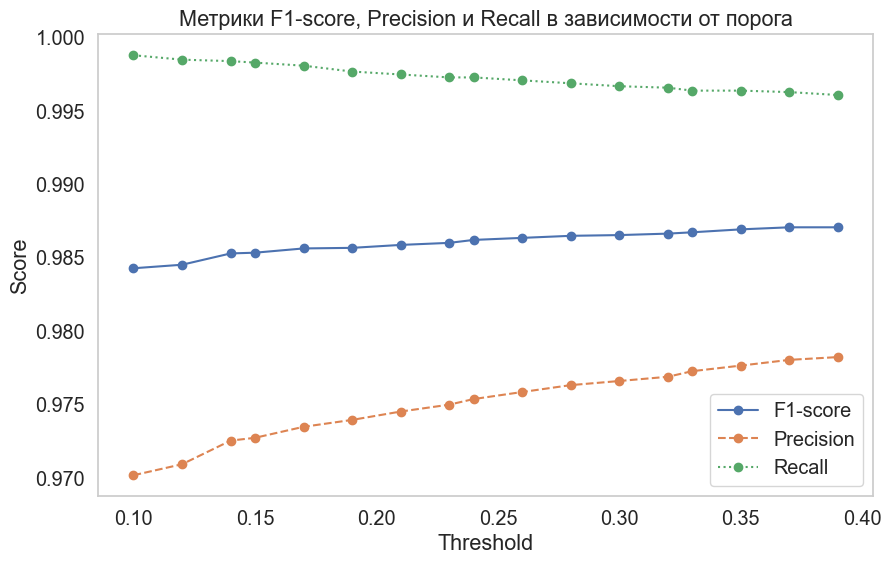

In [268]:
# Обучаю модель
model_log.fit(X_train_best, y_train)

# Получаем оценки вероятностей для класса
y_proba = model_log.predict_proba(X_valid_best)

# Создаю список пробных порогов классификации
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=50, endpoint=False)]

# Создаю пустые списки для сохранения промежуточных значений метрик
col_threshold = []
col_f1_score = []
col_precision = []
col_recall = []

# Оптимизация цикла для расчета метрик при разных порогах
best_f1 = 0
for i in thresholds:
    # Определяю принадлежность классам на основе порога
    proba = (y_proba[:, 1] >= i).astype(int)
    
    # Рассчитываю метрики
    f1 = round(f1_score(y_valid, proba), 5)
    precision = round(precision_score(y_valid, proba), 5)
    recall = round(recall_score(y_valid, proba), 5)
    
    # Сохраняю метрики в списки
    col_threshold.append(i)
    col_f1_score.append(f1)
    col_precision.append(precision)
    col_recall.append(recall)
    
    # Завершаю работу цикла, если F1 перестает улучшаться
    if f1 <= best_f1:
        break
    best_f1 = f1

# Помещаю результаты в датафрейм
result = pd.DataFrame({
    'Threshold': col_threshold,
    'F1-score': col_f1_score,
    'Precision': col_precision,
    'Recall': col_recall
})

# Вывожу 5 лучших результатов на экран с сортировкой по F1-score
pd.options.display.float_format = '{:,.5f}'.format
print("Топ-5 результатов метрик:")
display(result.sort_values(by='F1-score', ascending=False).head(5))
pd.options.display.float_format = '{:,.2f}'.format

# Визуализация зависимости F1-score от порога
plt.figure(figsize=(10, 6))
plt.plot(col_threshold, col_f1_score, marker='o', label='F1-score')
plt.plot(col_threshold, col_precision, marker='o', label='Precision', linestyle='--')
plt.plot(col_threshold, col_recall, marker='o', label='Recall', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Метрики F1-score, Precision и Recall в зависимости от порога')
plt.legend()
plt.grid()
plt.show()


**Выводы**
- **Оптимальный порог**: 0.39 с F1-score 0.98708, precision 0.97824, recall 0.99609.
- **Тренд**: Увеличение порога улучшает precision, но снижает recall.
- **Рекомендации**: Использовать порог 0.39 для баланса метрик.


In [269]:
# Инициализируем оптимальный порог
threshold = 0.39

# Предсказание на тестовом датасете

In [270]:
X_test = merged_df_test[
        [
            'funding_rounds',
            #'name',
            'last_funding_at',
            'countries_income_group',
            #'duration_to_funding_ratio',
            'lifetime',
            'first_funding_at',
            'lifetime_group',
            'funding_per_round',
            'funding_total_usd',
            #'activity_group',
            #'early_stage',
            #'category_first_word',
            #'funding_duration'
  
        ]
        
    ].copy()

In [271]:
# Подготовка тестового набора с помощью пайплайна
X_test_pr = vif_selector.transform(X_test)
X_test_pr_df = pd.DataFrame(X_test_pr, columns=X_train_pr.columns)

# Проверка на недостающие признаки после трансформации
missing_cols = set(X_train_pr.columns) - set(X_test_pr_df.columns)
if missing_cols:
    print(f"Добавляю недостающие признаки: {missing_cols}")
    for col in missing_cols:
        X_test_pr_df[col] = 0  # Заполняем недостающие колонки нулями
    
    # Переставляем колонки в нужном порядке
    X_test_pr_df = X_test_pr_df[X_train_pr.columns]


In [ ]:

# Проверка наличия всех признаков из features_names
missing_features = set(best_features) - set(X_test_pr_df.columns)
if missing_features:
    raise ValueError(f"Отсутствуют признаки из features_names: {missing_features}")

# Создаю новый набор данных с лучшими колонками
X_test_best = X_test_pr_df[list(best_features)]

# Выполняю предсказания с использованием порога `threshold`
y_test_proba = model_log.predict_proba(X_test_best)  # Вероятности
y_test = (y_test_proba[:, 1] >= threshold).astype(int)  # Предсказания

# Создаем датафрейм с предсказаниями
df_result = pd.DataFrame(
    data={
        'name': df[1]['name'],  # Проверка наличия колонки 'name'
        'status': ['operating' if x == 1 else 'closed' for x in y_test]
    }
)

# Проверка на пустой результат
if df_result.empty:
    raise ValueError("df_result пуст. Проверьте данные для предсказания.")

# Валидация результата
display(df_result.sample(5))

# Вывод количества объектов каждого статуса
print('Количество объектов каждого статуса в df_test:')
display(df_result['status'].value_counts())

# Выгрузка результатов в CSV
df_result.to_csv('Borodulin_v2.csv', index=False)
print("Файл 'Borodulin_v2.csv' успешно сохранен.")


name     status
55     Native Networks  operating
12159      SportStream  operating
10297       Perosphere  operating
6431         TopRealty  operating
11171           Linkua     closed

Количество объектов каждого статуса в df_test:


status
operating    12080
closed        1045
Name: count, dtype: int64

Файл 'Borodulin_v2.csv' успешно сохранен.


# 5. Анализ важности признаков (Шепли)

In [275]:
# инициализирую Explainer(), считаю значения SHAP
explainer = shap.Explainer(model_log.predict_proba, X_valid_best)
shap_values = explainer(X_valid_best)

PermutationExplainer explainer: 11088it [16:21, 11.18it/s]                           


In [276]:
k_best=int(optimal_k)

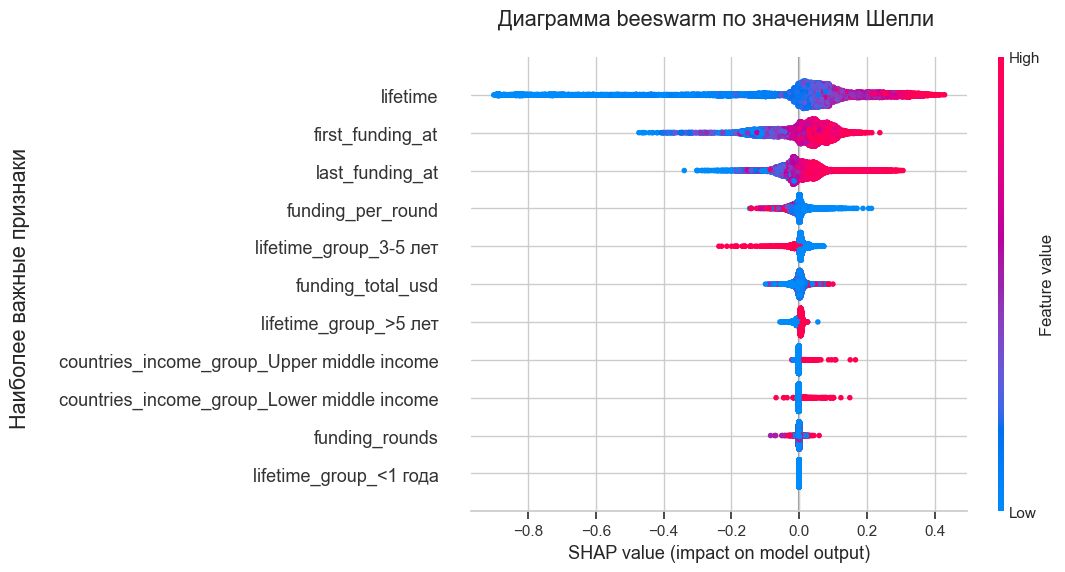

In [277]:
(
    shap.plots
    .beeswarm(shap_values[:,:,1], max_display=k_best, show=False)
    .set_title('Диаграмма beeswarm по значениям Шепли \n')
)

plt.ylabel('Наиболее важные признаки \n')
plt.show()

**Выводы по диаграмме SHAP (beeswarm plot)**

** 1. Важность признаков**
- **Наиболее важный признак** – `lifetime` (время существования стартапа).  
  - Чем больше продолжительность жизни стартапа, тем выше вероятность его успеха.  
  - Низкие значения `lifetime` (отмеченные синим) существенно увеличивают вероятность закрытия (отрицательные SHAP-значения).

** 2. Финансовые показатели**
- **`funding_per_round`** (объем финансирования на раунд) и **`funding_total_usd`** (общая сумма финансирования) оказывают значительное влияние.  
  - **Высокие значения** этих признаков (отмеченные красным) положительно коррелируют с успешностью стартапа.

**3. Группы по продолжительности жизни (`lifetime_group`)**
- **`lifetime_group_3-5 лет`** – оказывает наиболее позитивное влияние.  
- **`lifetime_group_>5 лет`** – также положительно влияет, но в меньшей степени.  
- **`lifetime_group_<1 года`** – ассоциируется с высокой вероятностью закрытия стартапа.

**4. Время финансирования**
- **`first_funding_at`** и **`last_funding_at`**:  
  - **Ранние даты** финансирования (отмеченные синим) могут указывать на снижение устойчивости стартапа.

**5. Географический контекст (доходы стран)**
- Стартапы из стран с уровнем дохода:  
  - **`Upper middle income`** – имеют положительное влияние на успех.  
  - **`Lower middle income`** – чаще сталкиваются с рисками закрытия (отрицательные SHAP-значения).

**6. Количество раундов финансирования**
- **`funding_rounds`** – большее количество раундов финансирования связано с более высокой устойчивостью стартапа.

---

**Основной вывод**
- Успех стартапа наиболее сильно зависит от продолжительности его существования, объема финансирования и географического контекста (уровня дохода страны).  
- **Краткосрочные стартапы с низким финансированием и в странах с низким доходом подвержены повышенным рискам закрытия.**
1. Важность признаков
- **Наиболее важный признак** – `lifetime` (время существования стартапа).  
  - Чем больше продолжительность жизни стартапа, тем выше вероятность его успеха.  
  - Низкие значения `lifetime` (отмеченные синим) существенно увеличивают вероятность закрытия (отрицательные SHAP-значения).

**2. Финансовые показатели**
- **`funding_per_round`** (объем финансирования на раунд) и **`funding_total_usd`** (общая сумма финансирования) оказывают значительное влияние.  
  - **Высокие значения** этих признаков (отмеченные красным) положительно коррелируют с успешностью стартапа.

**3. Группы по продолжительности жизни (`lifetime_group`)**
- **`lifetime_group_3-5 лет`** – оказывает наиболее позитивное влияние.  
- **`lifetime_group_>5 лет`** – также положительно влияет, но в меньшей степени.  
- **`lifetime_group_<1 года`** – ассоциируется с высокой вероятностью закрытия стартапа.

**4. Время финансирования**
- **`first_funding_at`** и **`last_funding_at`**:  
  - **Ранние даты** финансирования (отмеченные синим) могут указывать на снижение устойчивости стартапа.

**5. Географический контекст (доходы стран)**
- Стартапы из стран с уровнем дохода:  
  - **`Upper middle income`** – имеют положительное влияние на успех.  
  - **`Lower middle income`** – чаще сталкиваются с рисками закрытия (отрицательные SHAP-значения).

**6. Количество раундов финансирования**
- **`funding_rounds`** – большее количество раундов финансирования связано с более высокой устойчивостью стартапа.

---

**Основной вывод**
- Успех стартапа наиболее сильно зависит от продолжительности его существования, объема финансирования и географического контекста (уровня дохода страны).  
- **Краткосрочные стартапы с низким финансированием и в странах с низким доходом подвержены повышенным рискам закрытия.**


# 6. Итоговая оценка качества предсказания лучшей модели

Метрика F1 для лучшей модели с лучшими признаками:
- метрика F1 на валидационной выборке: 98.708%



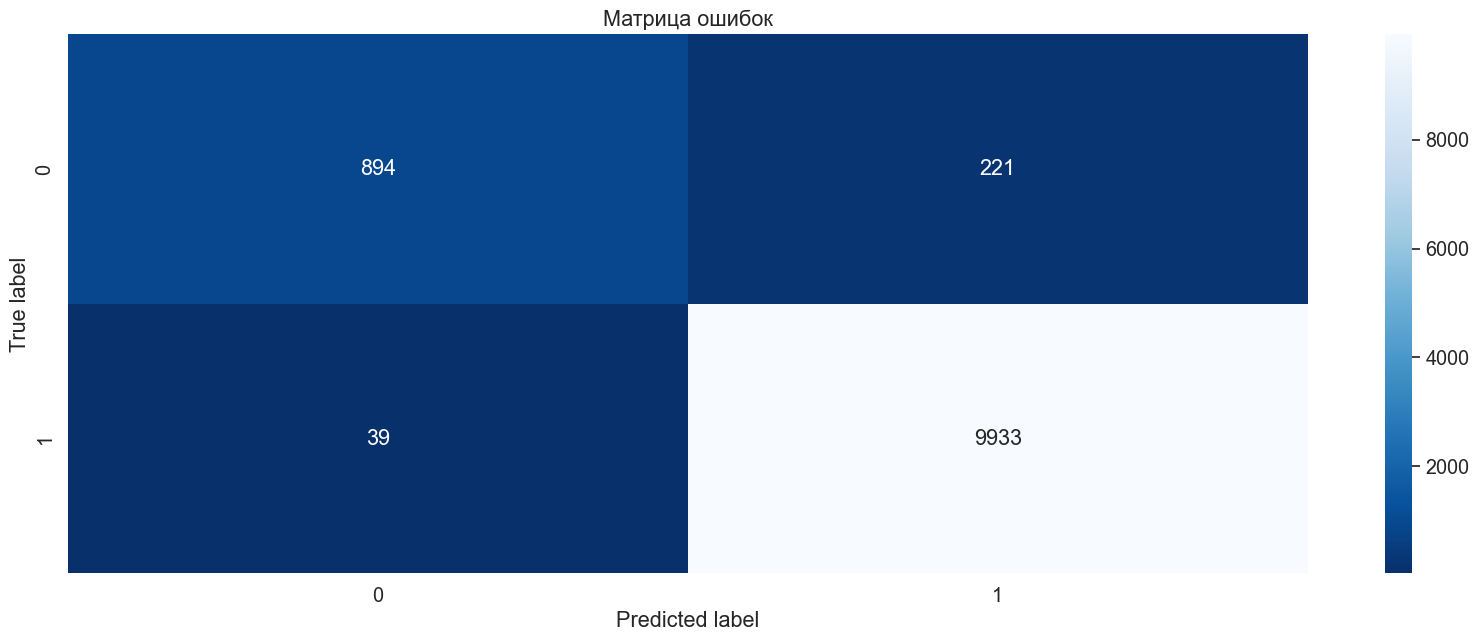

Дополнительные метрики:
- Precision: 0.978
- Recall: 0.996



In [278]:
# Задаю порог классификации
threshold = 0.39
# Определяю принадлежность классам на основе порога
y_pred_adj = (y_proba[:, 1] >= threshold).astype(int)

# Считаю метрику F1 на валидационной выборке
result_valid = f1_score(y_valid, y_pred_adj)

# Вывожу результаты на экран
print('Метрика F1 для лучшей модели с лучшими признаками:')
print(f'- метрика F1 на валидационной выборке: {result_valid * 100:.3f}%')
print()

# Подготавливаю матрицу ошибок и вывожу её на экран
cm = confusion_matrix(y_valid, y_pred_adj)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r').set_title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Расчёт Precision и Recall (дополнительно)
precision = precision_score(y_valid, y_pred_adj)
recall = recall_score(y_valid, y_pred_adj)

# Вывод Precision и Recall
print('Дополнительные метрики:')
print(f'- Precision: {precision:.3f}')
print(f'- Recall: {recall:.3f}')
print()


**Выводы:**
- **F1-score**: 98.71% — высокий баланс между точностью и полнотой.
- **Precision**: 0.978 — большинство положительных предсказаний корректны.
- **Recall**: 0.996 — модель практически не упускает положительные классы.
- **Матрица ошибок**:
  - Ложноположительные: 221
  - Ложноотрицательные: 39
- **Заключение**: Модель демонстрирует отличные результаты. Однако, для уменьшения количества ложных срабатываний (FP) можно повысить порог классификации.



# Отчет по исследованию данных о стартапах (1970-2018)

 **Задача:**  
Разработка модели для прогнозирования статуса стартапа (закрыт/действующий).  

---

**1. Вводные данные:**
- Объем тренировочного набора: 52,516 записей
- Объем тестового набора: 13,125 записей
- Период: 1970-2018 гг.
- Параметры: 13 колонок (название, сумма финансирования, страна, регион, даты основания, первого и последнего раундов и закрытия).

---

**2. Итоги исследования:**

**1. Анализ данных и выявленные зависимости:**
- **Корреляционный анализ:**
  - `lifetime_group` (0.666) — наибольшая корреляция с `status`.
  - `lifetime` (0.413) — умеренная корреляция с `status`.
  - `countries_income_group` (0.166) — уровень дохода страны влияет на успешность стартапа.
  - Финансирование (`funding_rounds`, `funding_total_usd`) оказывает слабое влияние на статус.

- **Продолжительность существования (`lifetime` и `lifetime_group`):**
  - Долгоживущие стартапы чаще остаются успешными.
  - `lifetime_group_3-5 лет` положительно влияет на статус.
  - `lifetime_group_<1 года` ассоциируется с повышенным риском закрытия.

- **Финансирование (`funding_total_usd`, `funding_rounds`):**
  - Основная масса данных — $1-$17 млн. 
  - Выбросы выше $50 млн исключены.
  - Модель показала слабую связь между объемом финансирования и статусом стартапа.

- **Географический контекст (`countries_income_group`):**
  - Стартапы из стран с высоким доходом (`High income`) чаще успешны.
  - Стартапы из `Lower middle income` подвержены повышенному риску закрытия.

- **Время финансирования:**
  - Ранние даты первого финансирования могут коррелировать с риском закрытия.

- **Группы активности (`activity_group`):**
  - Минимальная корреляция с `status` (0.162).

---

**2. Выводы по диаграмме SHAP:**
- **Ключевой признак:** `lifetime` — чем дольше существует стартап, тем выше вероятность его успеха.
- **Финансовые показатели:**
  - Высокие значения `funding_per_round` и `funding_total_usd` положительно влияют на статус.
- **Влияние уровня дохода страны:**
  - `Upper middle income` положительно коррелирует с успешностью стартапа.
  - `Lower middle income` — повышенный риск закрытия.

---

**3. Результаты модели машинного обучения:**
- **F1-score:** 98.71%
- **Precision:** 0.978
- **Recall:** 0.996
- **Матрица ошибок:**
  - Ложноположительные (FP): 221
  - Ложноотрицательные (FN): 39
- **Заключение:** Модель демонстрирует отличные результаты с высоким балансом между точностью и полнотой. 

---

**4. Рекомендации:**


1. **Кодирование категорий:** – `one-hot` или `target encoding` для `activity_group`, `countries_income_group`.
2. **Порог классификации:** – для снижения ложных предсказаний (повысить threshold).
3. **SMOTE/Взвешивание классов:** – для балансировки дисбаланса.
4. **Фичи-инжиниринг:**
   - Добавить признак `time_to_first_funding` (разница между `founded_at` и `first_funding_at`).
   - Применить логарифмическое преобразование для `funding_total_usd`.
5. **Тестирование гипотез:**
   - Исследовать зависимость `lifetime` и `countries_income_group` как мультифакторный признак.
   - Включить `lifetime`, `lifetime_group` и финансовые показатели как ключевые факторы успеха стартапов.

---

**Итог:**


Успех стартапа наиболее сильно зависит от продолжительности существования (`lifetime`), уровня дохода страны и стабильности финансирования. Для дальнейшего улучшения модели рекомендуется провести оптимизацию порога классификации, использовать балансировку классов и углубить анализ временных факторов.

